## Fermi/GBM NaI Data: GRB230307A CARMA (2,1) Model using TinyGP and Numpyro



In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import pickle
import numpy as np
import scipy.io

# Need both Jax and Tensorflow Probability 
import jax
# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import random
import tensorflow_probability.substrates.jax as tfp

# TinyGP for Gaussian Processes, JaxNS for sampling
from tinygp import GaussianProcess, kernels
from tinygp.kernels.quasisep import CARMA

from jaxns.utils import resample

#stingray imports
import stingray
from stingray import Lightcurve, Powerspectrum
from stingray.modeling.gpmodeling import get_kernel, get_mean
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# abbreviations for tensorflow distributions + bijectors
tfpd = tfp.distributions
tfpb = tfp.bijectors

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.contrib.nested_sampling import NestedSampler

import arviz as az

INFO[2023-11-02 09:04:53,360]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0000 00:00:1698912293.360166       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO[2023-11-02 09:04:53,361]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-11-02 09:04:53,371]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/grbsearch/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/Users/daniela/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn(

In [2]:
def get_ar_roots(qpo_width, qpo_centroid):
    """
    Return the roots of the characteristic AR(p) polynomial of the CARMA(p,q) process, given the lorentzian widths and
    centroids.

    :rtype : The roots of the autoregressive polynomial, a numpy array.
    :param qpo_width: The widths of the lorentzian functions defining the PSD.
    :param qpo_centroid: The centroids of the lorentzian functions defining the PSD. For all values of qpo_centroid
         that are greater than zero, the complex conjugate of the root will also be added.
    """
    ar_roots = []
    for i in range(len(qpo_centroid)):
        ar_roots.append(qpo_width[i] + 1j * qpo_centroid[i])
        if qpo_centroid[i] > 1e-10:
            # lorentzian is centered at a frequency > 0, so add complex conjugate of this root
            ar_roots.append(np.conjugate(ar_roots[-1]))
    if len(qpo_width) - len(qpo_centroid) == 1:
        # odd number of lorentzian functions, so add in low-frequency component
        ar_roots.append(qpo_width[-1] + 1j * 0.0)
    ar_roots = np.array(ar_roots)

    return -2.0 * np.pi * ar_roots

def power_spectrum(freq, ar_coef, ma_coefs=[1.0]):
    """
    FROM CARMApack (Kelly et al, 2014)
    
    Return the power spectrum for a CARMA(p,q) process calculated at the input frequencies.

    :param freq: The frequencies at which to calculate the PSD.
    :param sigma: The standard deviation driving white noise.
    :param ar_coef: The CARMA model autoregressive coefficients.
    :param ma_coefs: Coefficients of the moving average polynomial

    :rtype : The power spectrum at the input frequencies, a numpy array.
    """
    try:
        len(ma_coefs) <= len(ar_coef)
    except ValueError:
        "Size of ma_coefs must be less or equal to size of ar_roots."

    ma_poly = np.polyval(ma_coefs[::-1], 2.0 * np.pi * 1j * freq)  # Evaluate the polynomial in the PSD numerator
    ar_poly = np.polyval(ar_coef, 2.0 * np.pi * 1j * freq)  # Evaluate the polynomial in the PSD denominator
    pspec = np.abs(ma_poly) ** 2 / np.abs(ar_poly) ** 2
    return pspec

def skewgaussian(t, params):
    #parameter_names = ("logA", "t0", "logsig1", "logsig2", "logconst")
    logA = params[0]
    t0 = params[1]
    logsig1 = params[2]
    logsig2 = params[3]

    y = jnp.exp(logA) * jnp.where(
            t > t0,
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig2)**2))),
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig1)**2))),
        )
    return y

In [3]:
from tinygp.kernels.quasisep import CARMA

def get_max_posterior_parameters(res):
    """
    Returns the optimal parameters for the model based on the NUTS sampling
    """
    max_post_idx = jnp.argmax(res.log_posterior_density)
    map_points = jax.tree_map(lambda x: x[max_post_idx], res.samples)

    return map_points

def plot_posterior_predictive_carma(lc, res, nmean=50, ngrid=1000, ax=None, rkey=None):
    """
    Plot the posterior predictive distribution.
    Will plot the maximum posterior for the Gaussian Process, and 
    `nsamples` random draws from the mean function.
    
    Parameters
    ----------
    lc : stingray.Lightcurve object
        The light curve with the time series data 
        being modelled
    
    nsresults : jaxns.Results object
        The results from the sampling
        
    kernel_type : str
        The kernel type used in the modeling
        
    mean_type : str
        The type of the mean function used
    
    nmean: int, default 50
        The number of samples to use for drawing the 
        posterior
        
    ngrid: int, default 1000
        The number of points in the linear grid to 
        use for plotting the Gaussian Process
    
    ax : matplotlib.Axes object, default None
        A matplotlib.Axes object to plot into. If none is 
        given, a new Figure object will be created
        
    rkey : jax.randomPRNGKey object
        A random key for setting the sampling. If None,
        set to random.PRNGKey(1234)
    
    Returns
    -------
    ax : matplotlib.Axes object
        The matplotlib.axes object that the plot is 
        drawn in
    """
    if rkey is None:
        rkey = random.PRNGKey(1234)

    log_p = res.log_dp_mean #log-prob
    nsamples = res.total_num_samples # number of samples
    tgrid = np.linspace(lc.time[0], lc.time[-1], ngrid)

    # array for resampled samples
    samples_resampled = {}
    
    all_params = list(res.samples.keys())
    if "pred" in all_params:
        all_params.remove("pred")

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in all_params:
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    mean_var_names = ["log_amp", "t0", "log_sig1",
                    'log_sig2']

    mean_samples = dict((k, samples_resampled[k]) for k in mean_var_names)

    print("Resampling done, calculating maximum posterior model ...")

    maxpost_log = get_max_posterior_parameters(res)

    mean_params = [maxpost_log["log_amp"],
                   maxpost_log["t0"],
                   maxpost_log["log_sig1"],
                   maxpost_log["log_sig2"]]

    alpha = [jnp.exp(maxpost_log["log_alpha1"]), jnp.exp(maxpost_log["log_alpha2"])]
    beta = [jnp.exp(maxpost_log["log_beta"])]

    mean_val = skewgaussian(lc.time, mean_params)
    kernel = CARMA.init(alpha=alpha, beta=beta)

    gp = GaussianProcess(kernel, lc.time, diag=0.01, mean_value=mean_val)
    _, cond = gp.condition(lc.counts, tgrid, include_mean=True)


    mu = cond.loc + skewgaussian(tgrid, mean_params)
    std = np.sqrt(cond.variance)

    print("GP calculated, plotting GP and data ...")
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))

    ax.errorbar(lc.time, lc.counts, yerr=np.sqrt(lc.counts), 
                fmt="o", markersize=2, color="black",
                label="Observations")
    ax.plot(tgrid, mu, color="C0", label="Gaussian Process Maximum Posterior")
    ax.fill_between(tgrid, mu + std, mu - std, color="C0", alpha=0.3)

    idx_all = np.random.choice(np.arange(0,int(res.ESS), 1.0, dtype=int), 
                               size=nmean,
                               replace=False)
    print("calculating and plotting mean functions ...")
    for i, idx in enumerate(idx_all):
        #sk_log = dict((k, kernel_samples[k][idx]) for k in kernel_params)
        sm_log = [mean_samples[k][idx] for k in mean_var_names]

        mean_vals = skewgaussian(tgrid, sm_log)
        
        # legend only for the first line being drawn
        if i == 0:
            ax.plot(tgrid, mean_vals, color="orange", 
                    alpha=0.1, label="Mean function posterior draws")  
        else:
            ax.plot(tgrid, mean_vals, color="orange", alpha=0.1)

    # update legend opacity
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    return ax

def resample_posterior(res, rkey):
    """
    Resample Nested Sampling posterior sample 
    based on the weights to provide unbiased
    posterior samples.

    Parameters
    ----------
    res : jaxns.Results object
        The object with the posterior results of 
        the Nested Sampling run

    rkey : jax.RandomState key
        A random key for reproducibility

    Returns
    -------
    samples_resampled : dict
        A dictionary with the resampled samples
    """
    log_p = res.log_dp_mean #log-prob

    # array for resampled samples
    samples_resampled = {}

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in res.samples.keys():
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    return samples_resampled


## Modeling the Real Data

To load the data, we'll have to read them from an IDL .sav file, which will return a dictionary with the relevant columns as keywords and the values in arrays:

In [4]:
datadir = "/Users/daniela/work/data/grb230307A/"


In [5]:
def carma21_integral(t, y=None):
    
    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(5, 15.0))
    t0 = numpyro.sample("t0", dist.Uniform(0.0, 20))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-1, 3.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 4))

    params = [log_amp, t0, log_sig1,log_sig2]
    
    mean = skewgaussian(t, params)
    
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-20, 40))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-20, 40))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(2, 40))
        
    kernel = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2)], 
                        beta=[jnp.exp(log_beta)])
    
    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
        
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)

In [6]:
def carma21_integral_with_qpo(t, y=None):
    
    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(5, 11.5))
    t0 = numpyro.sample("t0", dist.Uniform(0.0, 20))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-1, 3.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 3.5))

    params = [log_amp, t0, log_sig1,log_sig2]
    
    mean = skewgaussian(t, params)
    
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-20, 20))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-20, 20))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(2, 20))
        
    kernel_carma = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2)], 
                        beta=[jnp.exp(log_beta)])

    # QPO kernel parameters
    log_aqpo = numpyro.sample("log_aqpo", dist.Uniform(1, 15))
    log_quality = numpyro.sample("log_quality", dist.Uniform(jnp.log(2.0), jnp.log(50.0)))
    log_omega = numpyro.sample("log_omega", dist.Uniform(np.log(2.*np.pi*0.1), np.log(2.*np.pi*5)))
    
    # QPO kernel
    kernel_qpo = kernels.quasisep.SHO(
            sigma=jnp.exp(log_aqpo),
            omega=jnp.exp(log_omega),
            quality = jnp.exp(log_quality)
        )
    
    # add kernels together
    kernel = kernel_carma + kernel_qpo

    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
        
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)

Let's sample this model, too:

In [7]:
import corner

In [8]:
def plot_posterior_predictive_carma_qpo(lc, res, nmean=50, ngrid=1000, ax=None, rkey=None):
    """
    Plot the posterior predictive distribution.
    Will plot the maximum posterior for the Gaussian Process, and 
    `nsamples` random draws from the mean function.
    
    Parameters
    ----------
    lc : stingray.Lightcurve object
        The light curve with the time series data 
        being modelled
    
    nsresults : jaxns.Results object
        The results from the sampling
        
    kernel_type : str
        The kernel type used in the modeling
        
    mean_type : str
        The type of the mean function used
    
    nmean: int, default 50
        The number of samples to use for drawing the 
        posterior
        
    ngrid: int, default 1000
        The number of points in the linear grid to 
        use for plotting the Gaussian Process
    
    ax : matplotlib.Axes object, default None
        A matplotlib.Axes object to plot into. If none is 
        given, a new Figure object will be created
        
    rkey : jax.randomPRNGKey object
        A random key for setting the sampling. If None,
        set to random.PRNGKey(1234)
    
    Returns
    -------
    ax : matplotlib.Axes object
        The matplotlib.axes object that the plot is 
        drawn in
    """
    if rkey is None:
        rkey = random.PRNGKey(1234)

    log_p = res.log_dp_mean #log-prob
    nsamples = res.total_num_samples # number of samples
    tgrid = np.linspace(lc.time[0], lc.time[-1], ngrid)

    # array for resampled samples
    samples_resampled = {}
    
    all_params = list(res.samples.keys())
    if "pred" in all_params:
        all_params.remove("pred")

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in all_params:
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    mean_var_names = ["log_amp", "t0", "log_sig1",
                    'log_sig2']

    mean_samples = dict((k, samples_resampled[k]) for k in mean_var_names)

    print("Resampling done, calculating maximum posterior model ...")

    maxpost_log = get_max_posterior_parameters(res)

    mean_params = [maxpost_log["log_amp"],
                   maxpost_log["t0"],
                   maxpost_log["log_sig1"],
                   maxpost_log["log_sig2"]]

    alpha = [jnp.exp(maxpost_log["log_alpha1"]), jnp.exp(maxpost_log["log_alpha2"])]
    beta = [jnp.exp(maxpost_log["log_beta"])]
    
    omega = jnp.exp(maxpost_log["log_omega"])
    quality = jnp.exp(maxpost_log["log_quality"])
    aqpo = jnp.exp(maxpost_log["log_aqpo"])

    mean_val = skewgaussian(lc.time, mean_params)
    kernel_carma = CARMA.init(alpha=alpha, beta=beta)
    kernel_qpo = kernels.quasisep.SHO(omega=omega, quality=quality, sigma=aqpo)
    
    kernel = kernel_carma + kernel_qpo

    gp = GaussianProcess(kernel, lc.time, diag=0.01, mean_value=mean_val)
    _, cond = gp.condition(lc.counts, tgrid, include_mean=True)


    mu = cond.loc + skewgaussian(tgrid, mean_params)
    std = np.sqrt(cond.variance)

    print("GP calculated, plotting GP and data ...")
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))

    ax.errorbar(lc.time, lc.counts, yerr=np.sqrt(lc.counts), 
                fmt="o", markersize=2, color="black",
                label="Observations")
    ax.plot(tgrid, mu, color="C0", label="Gaussian Process Maximum Posterior")
    ax.fill_between(tgrid, mu + std, mu - std, color="C0", alpha=0.3)

    idx_all = np.random.choice(np.arange(0,int(res.ESS), 1.0, dtype=int), 
                               size=nmean,
                               replace=False)
    print("calculating and plotting mean functions ...")
    for i, idx in enumerate(idx_all):
        #sk_log = dict((k, kernel_samples[k][idx]) for k in kernel_params)
        sm_log = [mean_samples[k][idx] for k in mean_var_names]

        mean_vals = skewgaussian(tgrid, sm_log)
        
        # legend only for the first line being drawn
        if i == 0:
            ax.plot(tgrid, mean_vals, color="orange", 
                    alpha=0.1, label="Mean function posterior draws")  
        else:
            ax.plot(tgrid, mean_vals, color="orange", alpha=0.1)

    # update legend opacity
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    return ax

## Fermi/GBM Data: NaI Detectors

Let's do the same for the Fermi/GBM data:

In [9]:
data = scipy.io.readsav(datadir+"bn230307656_na_mete.sav")
barytime = np.array(data["na_barytime"], dtype=float)
barytime = barytime
lc = Lightcurve.make_lightcurve(barytime, dt=0.05)

minind = lc.time.searchsorted(lc.tstart+24.5)
maxind = lc.time.searchsorted(lc.tstart + 84.5)
lc = lc.truncate(start=minind, stop=maxind, method="index")

mean_bkg = np.mean(lc.counts[-100:])

lc = Lightcurve(lc.time-lc.time[0], lc.counts-mean_bkg)
ps = Powerspectrum(lc, norm="leahy")

INFO[2023-11-02 09:07:02,551]: make_lightcurve: tseg: 144.99889838695526
INFO[2023-11-02 09:07:02,552]: make_lightcurve: timebin:  2899
INFO[2023-11-02 09:07:02,912]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-11-02 09:07:02,989]: Checking if light curve is sorted.
INFO[2023-11-02 09:07:03,079]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


<IPython.core.display.Javascript object>


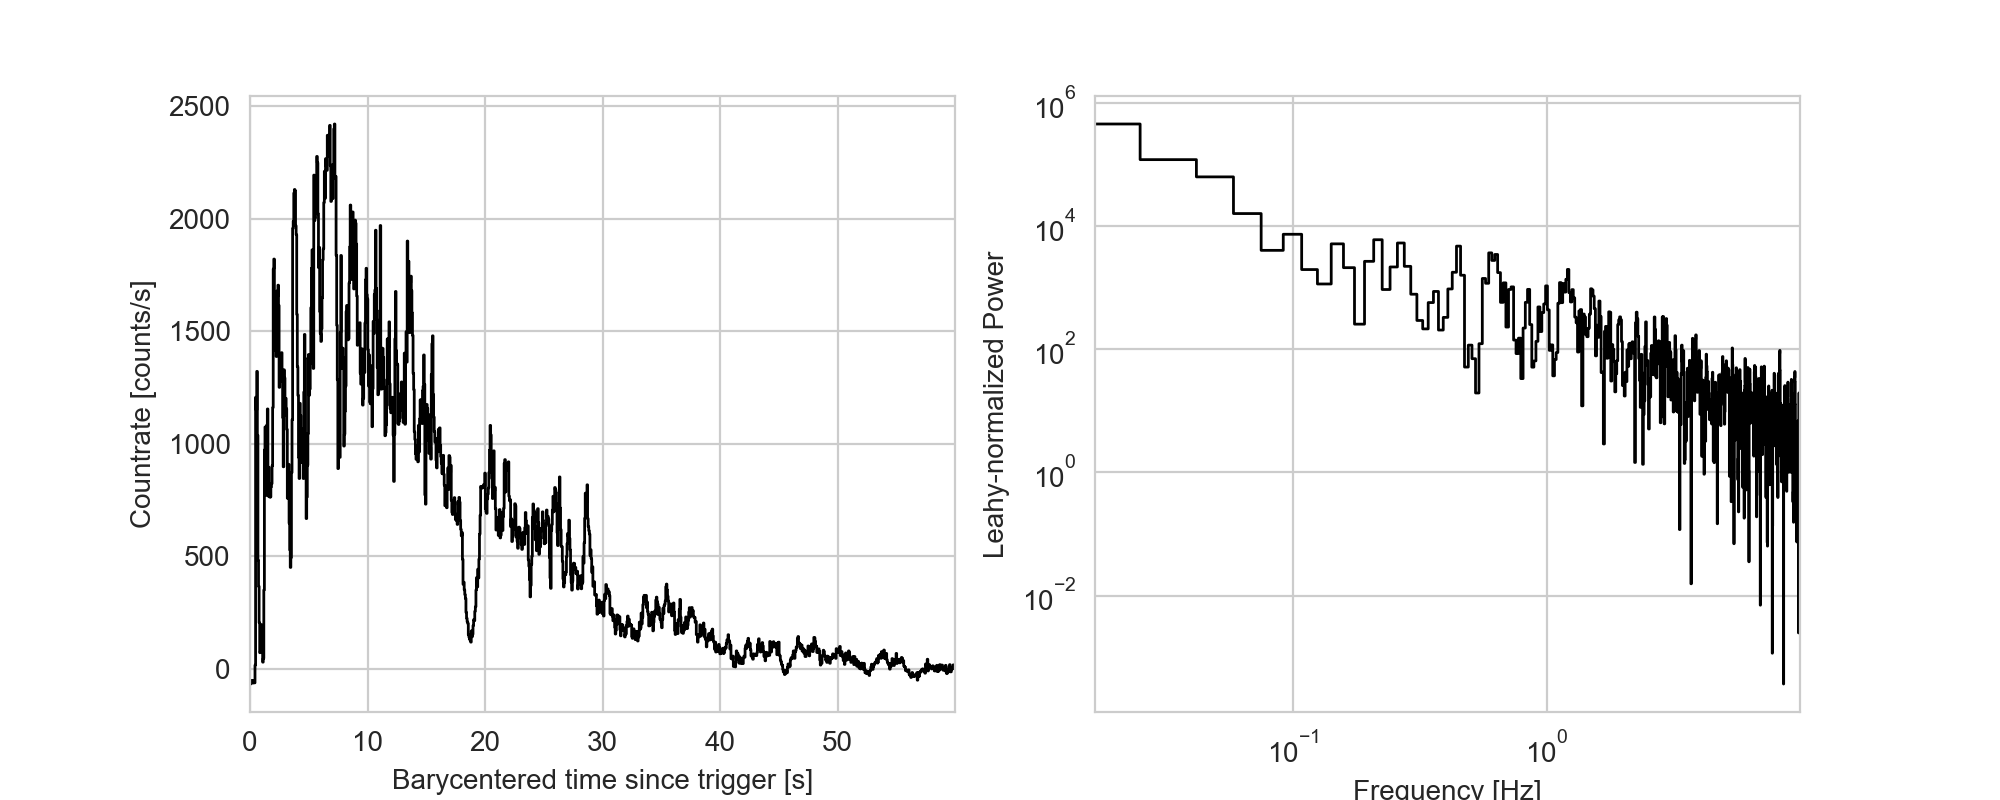

Text(0, 0.5, 'Leahy-normalized Power')

In [10]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.counts, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps.freq, ps.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps.freq[0], ps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

In [20]:
def carma21_fermina(t, y=None):
    
    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(6, 8.0))
    t0 = numpyro.sample("t0", dist.Uniform(0.0, 10))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-1, 3.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 3.5))

    params = [log_amp, t0, log_sig1,log_sig2]
    
    mean = skewgaussian(t, params)
    
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-20, 40))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-20, 40))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(2, 40))
        
    kernel = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2)], 
                        beta=[jnp.exp(log_beta)])
    
    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
        
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)


In [21]:
ns_na = NestedSampler(carma21_fermina, constructor_kwargs={"num_live_points":2500, 
                                                         "max_samples":1e6})
ns_na.run(random.PRNGKey(2001), lc.time, y=lc.counts)

In [68]:
import pickle
with open(datadir + "fermi_na_carma21_ns.pkl", "wb") as f:
    pickle.dump(ns_na, f)

In [8]:
#import pickle
#with open(datadir + "fermi_na_carma21_ns.pkl", "rb") as f:
#    ns_na = pickle.load(f)

In [22]:
samples, weights = ns_na.get_weighted_samples()

ns_na.print_summary()


--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 12196769
# samples: 70000
# slices: 1312500.0
# slices / acceptance: 21.0
# likelihood evals / sample: 174.2
# likelihood evals / slice: 9.2
--------
logZ=-7272.55 +- 0.082
H=7300.0
ESS=14201
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: -0.0 +- 7.3 | -14.2 / 4.5 / 4.8 | 4.7 | 4.7
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha2: 12.0 +- 11.0 | 3.0 / 4.0 / 32.0 | 4.0 | 4.0
--------
log_amp: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_amp: 7.1 +- 0.41 | 6.36 / 7.3 / 7.38 | 7.34 | 7.34
--------
log_beta: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta: 18.0 +- 11.0 | 10.0 / 10.0 / 38.0 | 10.0 | 10.0
--------
log_sig1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_sig1: 0.3 +- 1.1 | -0.7 / -0.3 / 2.1 | -0.1 | -0.

pred[118]: 930.0 +- 910.0 | 250.0 / 370.0 / 2370.0 | 310.0 | 310.0
pred[119]: 710.0 +- 880.0 | 60.0 / 170.0 / 2140.0 | 120.0 | 120.0
pred[120]: 600.0 +- 880.0 | -60.0 / 50.0 / 2020.0 | -0.0 | -0.0
pred[121]: 560.0 +- 880.0 | -90.0 / 20.0 / 1980.0 | -30.0 | -30.0
pred[122]: 620.0 +- 880.0 | -30.0 / 80.0 / 2050.0 | 20.0 | 20.0
pred[123]: 750.0 +- 880.0 | 100.0 / 210.0 / 2180.0 | 160.0 | 160.0
pred[124]: 910.0 +- 890.0 | 250.0 / 360.0 / 2340.0 | 300.0 | 300.0
pred[125]: 1000.0 +- 880.0 | 340.0 / 460.0 / 2430.0 | 400.0 | 400.0
pred[126]: 1180.0 +- 900.0 | 510.0 / 630.0 / 2620.0 | 570.0 | 570.0
pred[127]: 1300.0 +- 910.0 | 620.0 / 730.0 / 2770.0 | 680.0 | 680.0
pred[128]: 1240.0 +- 870.0 | 600.0 / 710.0 / 2660.0 | 650.0 | 650.0
pred[129]: 1360.0 +- 900.0 | 680.0 / 800.0 / 2820.0 | 740.0 | 740.0
pred[130]: 1350.0 +- 890.0 | 690.0 / 800.0 / 2790.0 | 750.0 | 750.0
pred[131]: 1350.0 +- 870.0 | 700.0 / 820.0 / 2750.0 | 760.0 | 760.0
pred[132]: 1450.0 +- 900.0 | 780.0 / 900.0 / 2910.0 | 840.0 | 8

pred[264]: 620.0 +- 950.0 | -90.0 / -10.0 / 2110.0 | -50.0 | -50.0
pred[265]: 850.0 +- 980.0 | 110.0 / 190.0 / 2400.0 | 150.0 | 150.0
pred[266]: 950.0 +- 980.0 | 210.0 / 290.0 / 2510.0 | 250.0 | 250.0
pred[267]: 920.0 +- 940.0 | 210.0 / 290.0 / 2430.0 | 250.0 | 250.0
pred[268]: 1300.0 +- 1000.0 | 500.0 / 600.0 / 2900.0 | 600.0 | 600.0
pred[269]: 1320.0 +- 960.0 | 590.0 / 670.0 / 2840.0 | 640.0 | 640.0
pred[270]: 1290.0 +- 980.0 | 540.0 / 620.0 / 2850.0 | 590.0 | 590.0
pred[271]: 1120.0 +- 970.0 | 390.0 / 470.0 / 2660.0 | 430.0 | 430.0
pred[272]: 1030.0 +- 960.0 | 310.0 / 390.0 / 2560.0 | 350.0 | 350.0
pred[273]: 1210.0 +- 990.0 | 450.0 / 530.0 / 2780.0 | 500.0 | 500.0
pred[274]: 1250.0 +- 980.0 | 510.0 / 590.0 / 2820.0 | 550.0 | 550.0
pred[275]: 1190.0 +- 970.0 | 460.0 / 540.0 / 2750.0 | 500.0 | 500.0
pred[276]: 1090.0 +- 960.0 | 360.0 / 440.0 / 2620.0 | 410.0 | 410.0
pred[277]: 980.0 +- 960.0 | 250.0 / 330.0 / 2530.0 | 300.0 | 300.0
pred[278]: 830.0 +- 950.0 | 110.0 / 190.0 / 2340.0 |

pred[395]: 650.0 +- 950.0 | -70.0 / 10.0 / 2170.0 | -20.0 | -20.0
pred[396]: 660.0 +- 950.0 | -70.0 / 20.0 / 2180.0 | -10.0 | -10.0
pred[397]: 660.0 +- 940.0 | -60.0 / 20.0 / 2180.0 | -0.0 | -0.0
pred[398]: 680.0 +- 950.0 | -50.0 / 30.0 / 2210.0 | 0.0 | 0.0
pred[399]: 660.0 +- 930.0 | -40.0 / 40.0 / 2180.0 | 10.0 | 10.0
pred[400]: 800.0 +- 1000.0 | -0.0 / 100.0 / 2400.0 | 0.0 | 0.0
pred[401]: 550.0 +- 900.0 | -130.0 / -50.0 / 2020.0 | -80.0 | -80.0
pred[402]: 560.0 +- 950.0 | -160.0 / -80.0 / 2080.0 | -110.0 | -110.0
pred[403]: 540.0 +- 920.0 | -160.0 / -70.0 / 2020.0 | -100.0 | -100.0
pred[404]: 630.0 +- 950.0 | -100.0 / -20.0 / 2140.0 | -40.0 | -40.0
pred[405]: 650.0 +- 930.0 | -70.0 / 10.0 / 2140.0 | -10.0 | -10.0
pred[406]: 680.0 +- 930.0 | -40.0 / 40.0 / 2180.0 | 20.0 | 20.0
pred[407]: 750.0 +- 940.0 | 30.0 / 110.0 / 2270.0 | 90.0 | 90.0
pred[408]: 860.0 +- 950.0 | 140.0 / 220.0 / 2370.0 | 190.0 | 190.0
pred[409]: 970.0 +- 960.0 | 230.0 / 320.0 / 2500.0 | 290.0 | 290.0
pred[410]: 

pred[533]: 470.0 +- 770.0 | -120.0 / -20.0 / 1700.0 | -50.0 | -50.0
pred[534]: 430.0 +- 770.0 | -150.0 / -60.0 / 1660.0 | -80.0 | -80.0
pred[535]: 450.0 +- 770.0 | -130.0 / -40.0 / 1680.0 | -60.0 | -60.0
pred[536]: 510.0 +- 790.0 | -90.0 / 10.0 / 1780.0 | -20.0 | -20.0
pred[537]: 500.0 +- 780.0 | -90.0 / 0.0 / 1740.0 | -20.0 | -20.0
pred[538]: 510.0 +- 770.0 | -70.0 / 20.0 / 1760.0 | -10.0 | -10.0
pred[539]: 600.0 +- 800.0 | -10.0 / 90.0 / 1870.0 | 60.0 | 60.0
pred[540]: 660.0 +- 790.0 | 60.0 / 150.0 / 1920.0 | 120.0 | 120.0
pred[541]: 720.0 +- 810.0 | 100.0 / 190.0 / 2020.0 | 170.0 | 170.0
pred[542]: 690.0 +- 780.0 | 100.0 / 190.0 / 1920.0 | 170.0 | 170.0
pred[543]: 800.0 +- 840.0 | 150.0 / 250.0 / 2140.0 | 220.0 | 220.0
pred[544]: 680.0 +- 780.0 | 90.0 / 190.0 / 1930.0 | 160.0 | 160.0
pred[545]: 640.0 +- 800.0 | 30.0 / 130.0 / 1920.0 | 100.0 | 100.0
pred[546]: 500.0 +- 750.0 | -60.0 / 30.0 / 1720.0 | 0.0 | 0.0
pred[547]: 480.0 +- 780.0 | -100.0 / -10.0 / 1730.0 | -40.0 | -40.0
pred[5

pred[673]: 500.0 +- 640.0 | 40.0 / 120.0 / 1540.0 | 100.0 | 100.0
pred[674]: 550.0 +- 670.0 | 70.0 / 140.0 / 1630.0 | 120.0 | 120.0
pred[675]: 480.0 +- 640.0 | 20.0 / 100.0 / 1500.0 | 80.0 | 80.0
pred[676]: 530.0 +- 670.0 | 40.0 / 120.0 / 1630.0 | 100.0 | 100.0
pred[677]: 460.0 +- 640.0 | 0.0 / 80.0 / 1510.0 | 60.0 | 60.0
pred[678]: 460.0 +- 660.0 | -10.0 / 70.0 / 1540.0 | 50.0 | 50.0
pred[679]: 390.0 +- 630.0 | -60.0 / 20.0 / 1420.0 | 0.0 | 0.0
pred[680]: 400.0 +- 640.0 | -60.0 / 20.0 / 1440.0 | 0.0 | 0.0
pred[681]: 410.0 +- 640.0 | -50.0 / 30.0 / 1460.0 | 10.0 | 10.0
pred[682]: 400.0 +- 630.0 | -50.0 / 30.0 / 1420.0 | 10.0 | 10.0
pred[683]: 450.0 +- 640.0 | -10.0 / 70.0 / 1490.0 | 50.0 | 50.0
pred[684]: 460.0 +- 630.0 | 10.0 / 80.0 / 1490.0 | 70.0 | 70.0
pred[685]: 470.0 +- 650.0 | 0.0 / 80.0 / 1540.0 | 60.0 | 60.0
pred[686]: 360.0 +- 610.0 | -70.0 / 10.0 / 1340.0 | -10.0 | -10.0
pred[687]: 420.0 +- 640.0 | -30.0 / 40.0 / 1460.0 | 20.0 | 20.0
pred[688]: 440.0 +- 630.0 | -0.0 / 70.0 /

pred[812]: 450.0 +- 620.0 | 20.0 / 70.0 / 1470.0 | 60.0 | 60.0
pred[813]: 430.0 +- 610.0 | 20.0 / 60.0 / 1440.0 | 50.0 | 50.0
pred[814]: 470.0 +- 630.0 | 40.0 / 90.0 / 1500.0 | 80.0 | 80.0
pred[815]: 440.0 +- 610.0 | 20.0 / 70.0 / 1440.0 | 60.0 | 60.0
pred[816]: 440.0 +- 620.0 | 10.0 / 60.0 / 1470.0 | 50.0 | 50.0
pred[817]: 390.0 +- 600.0 | -20.0 / 30.0 / 1390.0 | 20.0 | 20.0
pred[818]: 440.0 +- 640.0 | -0.0 / 50.0 / 1470.0 | 40.0 | 40.0
pred[819]: 350.0 +- 610.0 | -60.0 / -10.0 / 1340.0 | -20.0 | -20.0
pred[820]: 380.0 +- 630.0 | -50.0 / -0.0 / 1400.0 | -10.0 | -10.0
pred[821]: 350.0 +- 610.0 | -60.0 / -10.0 / 1360.0 | -20.0 | -20.0
pred[822]: 380.0 +- 630.0 | -50.0 / -0.0 / 1410.0 | -10.0 | -10.0
pred[823]: 310.0 +- 600.0 | -90.0 / -50.0 / 1300.0 | -60.0 | -60.0
pred[824]: 340.0 +- 620.0 | -70.0 / -30.0 / 1350.0 | -40.0 | -40.0
pred[825]: 330.0 +- 610.0 | -80.0 / -40.0 / 1320.0 | -50.0 | -50.0
pred[826]: 320.0 +- 610.0 | -90.0 / -50.0 / 1310.0 | -60.0 | -60.0
pred[827]: 340.0 +- 600.

pred[946]: 410.0 +- 610.0 | 10.0 / 40.0 / 1400.0 | 30.0 | 30.0
pred[947]: 420.0 +- 610.0 | 30.0 / 50.0 / 1420.0 | 50.0 | 50.0
pred[948]: 440.0 +- 610.0 | 40.0 / 60.0 / 1430.0 | 50.0 | 50.0
pred[949]: 430.0 +- 600.0 | 40.0 / 60.0 / 1420.0 | 50.0 | 50.0
pred[950]: 470.0 +- 620.0 | 60.0 / 80.0 / 1480.0 | 80.0 | 80.0
pred[951]: 450.0 +- 610.0 | 50.0 / 70.0 / 1460.0 | 70.0 | 70.0
pred[952]: 410.0 +- 600.0 | 20.0 / 40.0 / 1390.0 | 40.0 | 40.0
pred[953]: 430.0 +- 600.0 | 40.0 / 60.0 / 1420.0 | 60.0 | 60.0
pred[954]: 460.0 +- 610.0 | 60.0 / 80.0 / 1450.0 | 80.0 | 80.0
pred[955]: 450.0 +- 600.0 | 60.0 / 90.0 / 1440.0 | 80.0 | 80.0
pred[956]: 470.0 +- 610.0 | 70.0 / 90.0 / 1470.0 | 90.0 | 90.0
pred[957]: 450.0 +- 600.0 | 50.0 / 80.0 / 1440.0 | 70.0 | 70.0
pred[958]: 430.0 +- 600.0 | 40.0 / 60.0 / 1420.0 | 60.0 | 60.0
pred[959]: 440.0 +- 600.0 | 50.0 / 70.0 / 1420.0 | 70.0 | 70.0
pred[960]: 510.0 +- 620.0 | 100.0 / 120.0 / 1520.0 | 120.0 | 120.0
pred[961]: 500.0 +- 610.0 | 100.0 / 120.0 / 1500.0 

pred[1083]: 450.0 +- 610.0 | 50.0 / 60.0 / 1460.0 | 60.0 | 60.0
pred[1084]: 410.0 +- 600.0 | 30.0 / 40.0 / 1390.0 | 30.0 | 30.0
pred[1085]: 400.0 +- 600.0 | 20.0 / 20.0 / 1390.0 | 20.0 | 20.0
pred[1086]: 390.0 +- 600.0 | 10.0 / 20.0 / 1380.0 | 20.0 | 20.0
pred[1087]: 380.0 +- 600.0 | 0.0 / 10.0 / 1370.0 | 10.0 | 10.0
pred[1088]: 400.0 +- 610.0 | 10.0 / 20.0 / 1390.0 | 20.0 | 20.0
pred[1089]: 360.0 +- 600.0 | -10.0 / -10.0 / 1340.0 | -10.0 | -10.0
pred[1090]: 390.0 +- 610.0 | 0.0 / 10.0 / 1390.0 | 10.0 | 10.0
pred[1091]: 380.0 +- 600.0 | -0.0 / 10.0 / 1370.0 | 10.0 | 10.0
pred[1092]: 390.0 +- 600.0 | 10.0 / 20.0 / 1390.0 | 20.0 | 20.0
pred[1093]: 430.0 +- 620.0 | 30.0 / 40.0 / 1460.0 | 40.0 | 40.0
pred[1094]: 380.0 +- 600.0 | 10.0 / 10.0 / 1380.0 | 10.0 | 10.0
pred[1095]: 430.0 +- 620.0 | 30.0 / 40.0 / 1440.0 | 40.0 | 40.0
pred[1096]: 380.0 +- 600.0 | 0.0 / 10.0 / 1360.0 | 10.0 | 10.0
pred[1097]: 420.0 +- 610.0 | 30.0 / 30.0 / 1430.0 | 30.0 | 30.0
pred[1098]: 420.0 +- 610.0 | 30.0 / 40.

In [23]:
mean_var_names = ["log_amp", "t0", "log_sig1",
                  'log_sig2']

kernel_var_names = ["log_alpha1", "log_alpha2",
                    "log_beta"]

var_names = np.hstack([mean_var_names, kernel_var_names])

post_samples = samples["log_amp"]

for v in var_names[1:]:
    post_samples = np.vstack([post_samples, samples[v]])


In [17]:
import corner

<IPython.core.display.Javascript object>


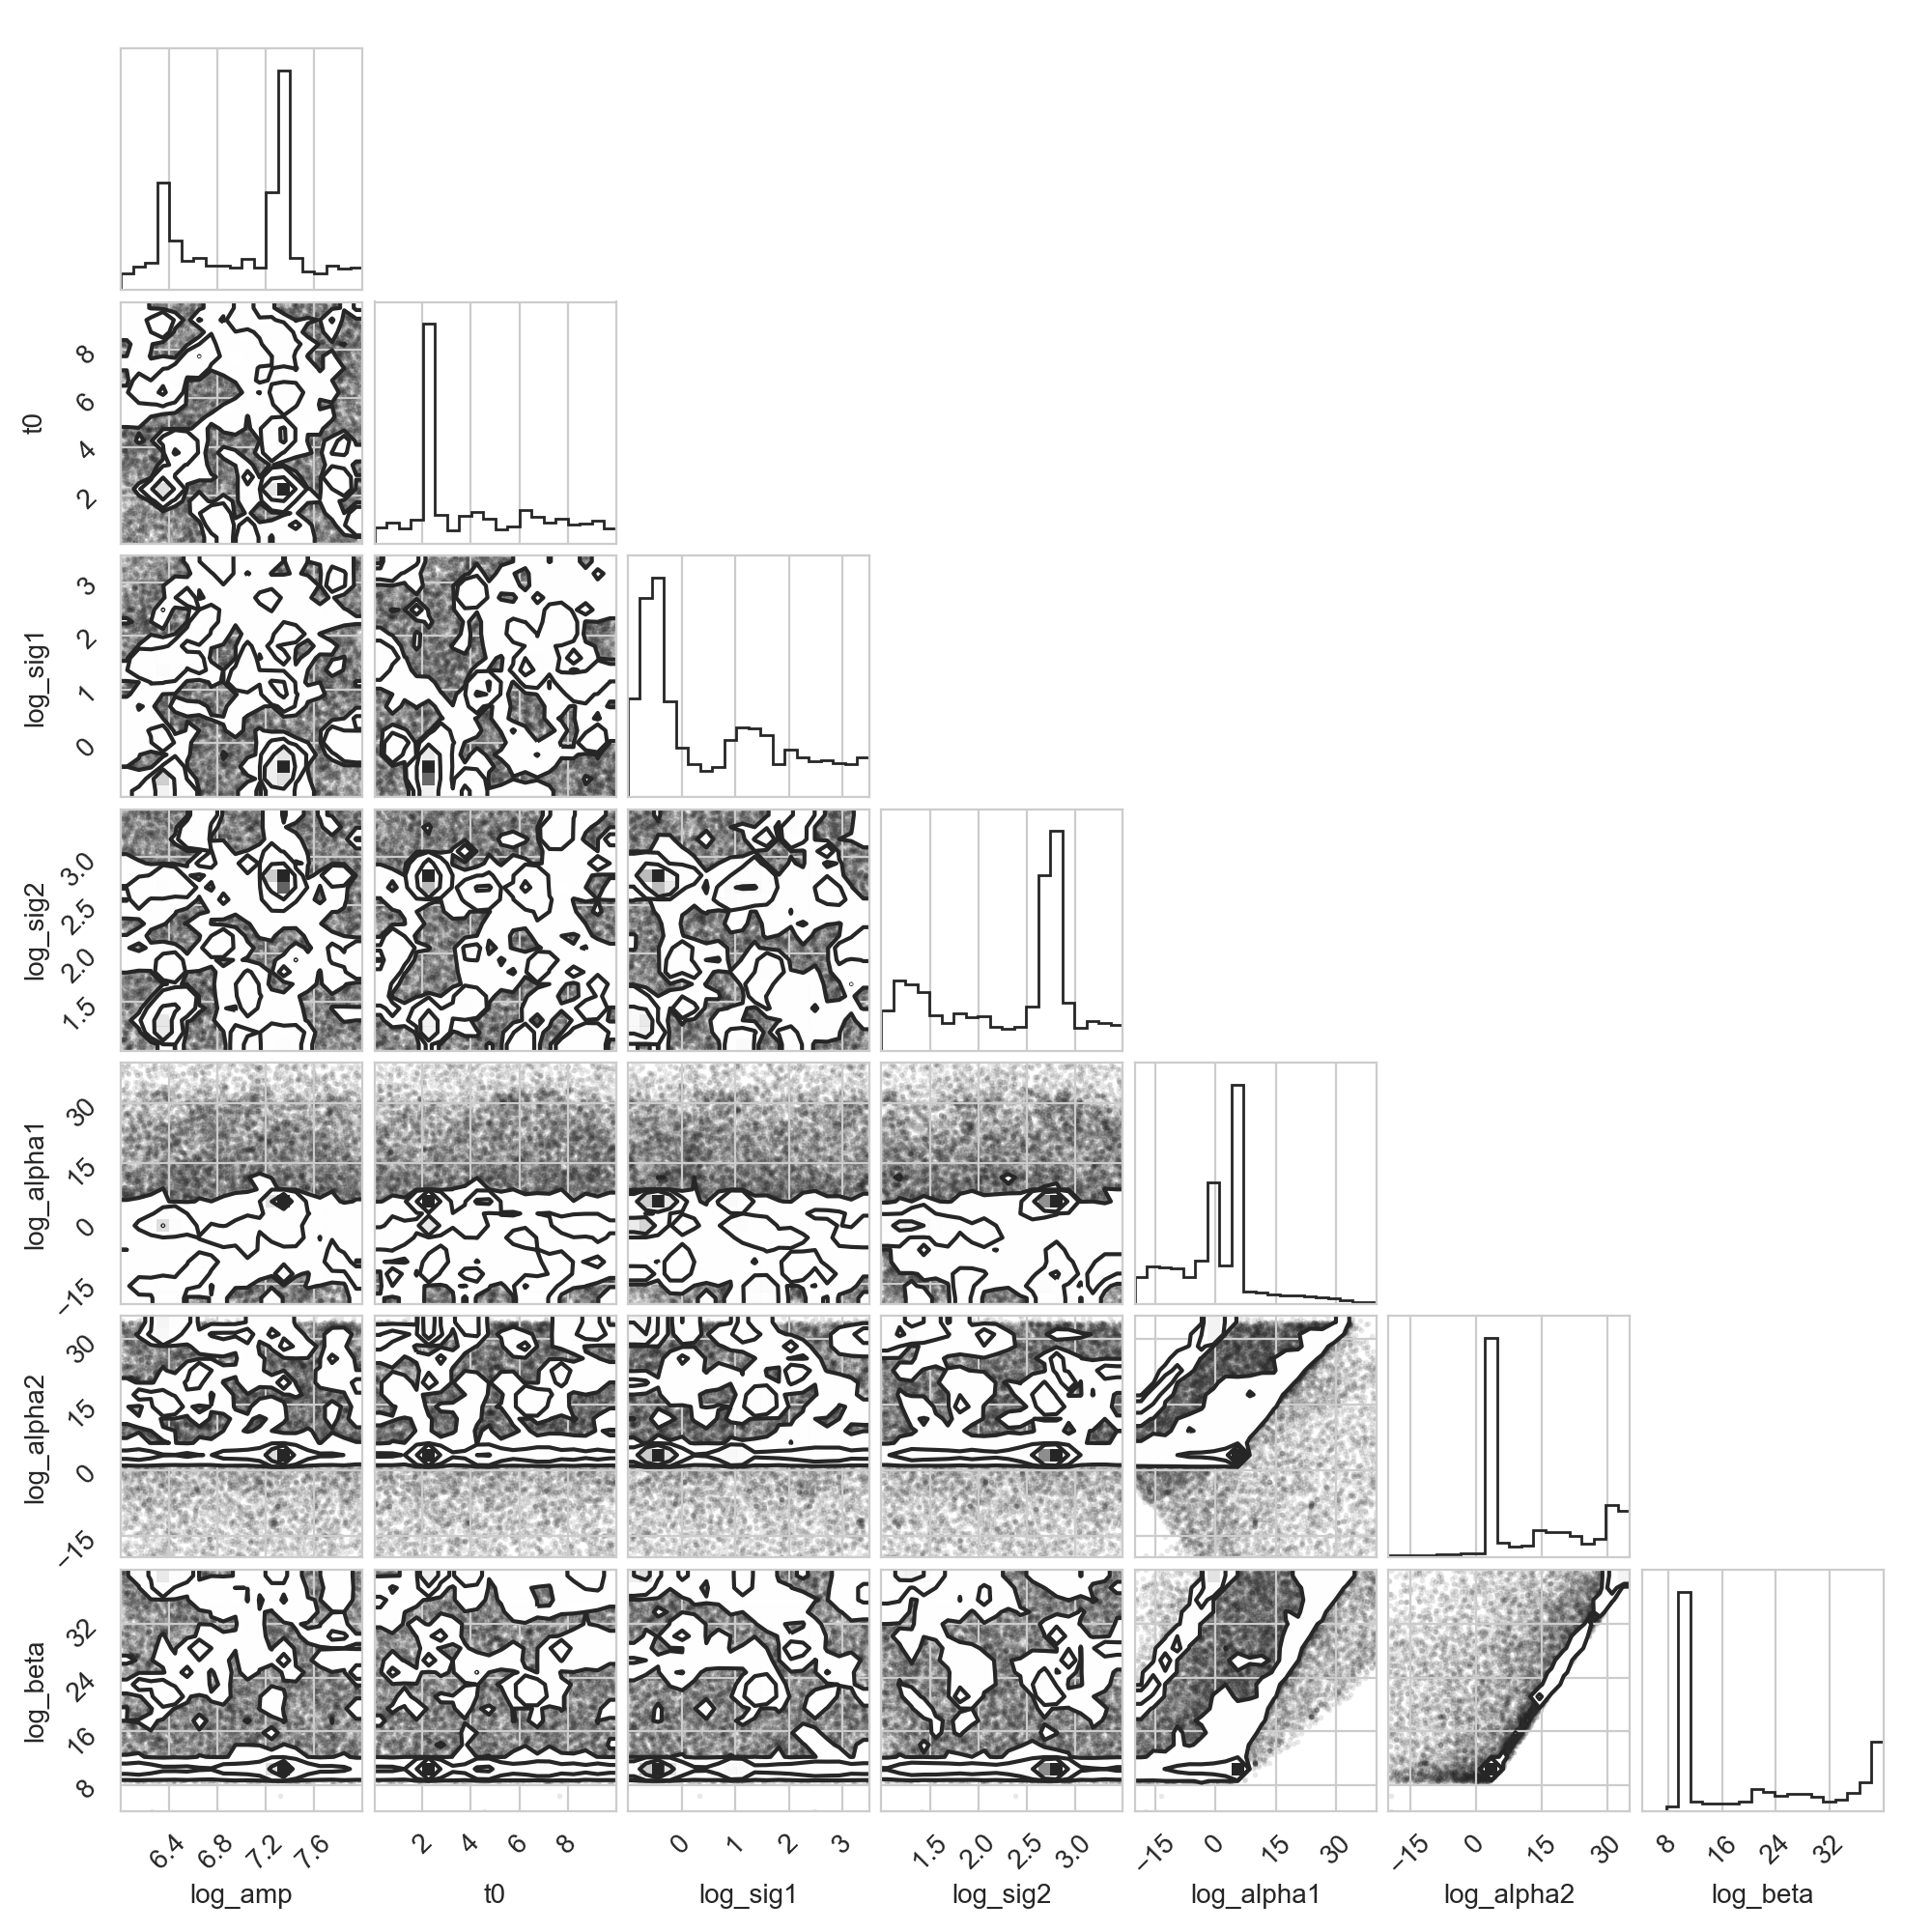

WARNING[2023-11-02 13:49:45,531]: Too few points to create valid contours
WARNING[2023-11-02 13:49:45,562]: Too few points to create valid contours


In [24]:
fig = plt.figure(figsize=(10,10))
fig = corner.corner(post_samples.T, labels=var_names, fig=fig)

<IPython.core.display.Javascript object>


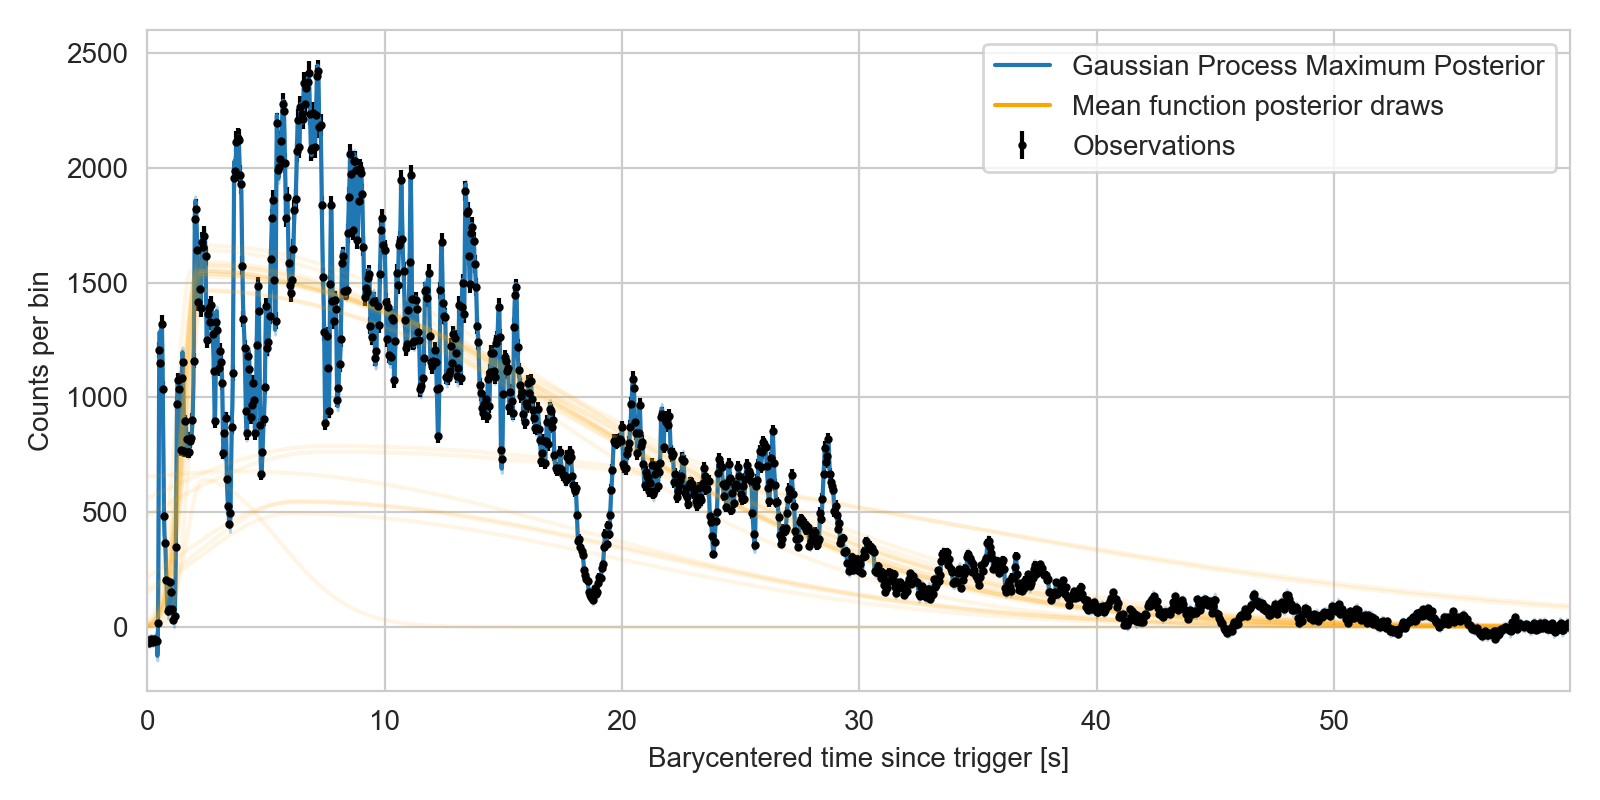

Resampling done, calculating maximum posterior model ...
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


In [25]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8,4))

ax1 = plot_posterior_predictive_carma(lc, ns_na._results,
                               nmean=20, ngrid=3000, ax=ax1, rkey=None)

ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Counts per bin")

#freq_post = np.exp()
#ax2.hist(1/freq_post, bins=100, histtype="stepfilled", alpha=0.5, 
#         color="black", range=[0.75,0.9], density=True)
#ax2.set_xlabel("QPO Period [s]")
#ax2.set_ylabel("Posterior probability density")
fig.tight_layout()



### Model with a QPO

In [29]:
def carma21_fermina_with_qpo(t, y=None):
    
    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(6, 8.0))
    t0 = numpyro.sample("t0", dist.Uniform(0.0, 10))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-1, 3.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 3.5))
    
    params = [log_amp, t0, log_sig1,log_sig2]
    
    mean = skewgaussian(t, params)
    
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-20, 20))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-20, 20))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(2, 20))
        
    kernel_carma = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2)], 
                        beta=[jnp.exp(log_beta)])

    # QPO kernel parameters
    log_aqpo = numpyro.sample("log_aqpo", dist.Uniform(1, 15))
    log_quality = numpyro.sample("log_quality", dist.Uniform(jnp.log(2.0), jnp.log(50.0)))
    log_omega = numpyro.sample("log_omega", dist.Uniform(np.log(2.*np.pi*0.1), np.log(2.*np.pi*5)))
    
    # QPO kernel
    kernel_qpo = kernels.quasisep.SHO(
            sigma=jnp.exp(log_aqpo),
            omega=jnp.exp(log_omega),
            quality = jnp.exp(log_quality)
        )
    
    # add kernels together
    kernel = kernel_carma + kernel_qpo

    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
        
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)

Let's sample this model, too:

In [30]:
ns_qpo = NestedSampler(carma21_fermina_with_qpo, constructor_kwargs={"num_live_points":2500, 
                                                                     "max_samples":100000})
ns_qpo.run(random.PRNGKey(2020), lc.time, y=lc.counts, )

In [108]:
import pickle
with open(datadir + "fermi_na_carma21_qpo_ns.pkl", "wb") as f:
    pickle.dump(ns_qpo, f)

In [109]:
samples_qpo, weights_qpo = ns_qpo.get_weighted_samples()

ns_qpo.print_summary()


--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 1917595
# samples: 9350
# slices: 272250.0
# slices / acceptance: 33.0
# likelihood evals / sample: 205.1
# likelihood evals / slice: 7.0
--------
logZ=-7210.46 +- 0.3
H=7200.0
ESS=955
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: 4.08 +- 0.16 | 3.87 / 4.09 / 4.28 | 4.11 | 4.11
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha2: 3.36 +- 0.11 | 3.22 / 3.36 / 3.51 | 3.33 | 3.33
--------
log_amp: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_amp: 7.28 +- 0.06 | 7.208 / 7.275 / 7.358 | 7.305 | 7.305
--------
log_aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_aqpo: 3.4 +- 1.1 | 2.0 / 3.6 / 4.8 | 5.4 | 5.4
--------
log_beta: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta: 9.705 +- 0.077 | 9.612 / 9.702 / 9.806 | 9

pred[192]: -19.0 +- 64.0 | -103.0 / -15.0 / 58.0 | -46.0 | -46.0
pred[193]: -9.0 +- 64.0 | -93.0 / -5.0 / 68.0 | -36.0 | -36.0
pred[194]: 117.0 +- 64.0 | 31.0 / 120.0 / 192.0 | 89.0 | 89.0
pred[195]: 138.0 +- 64.0 | 54.0 / 142.0 / 213.0 | 111.0 | 111.0
pred[196]: 303.0 +- 64.0 | 219.0 / 307.0 / 378.0 | 275.0 | 275.0
pred[197]: 482.0 +- 63.0 | 398.0 / 485.0 / 556.0 | 455.0 | 455.0
pred[198]: 534.0 +- 63.0 | 450.0 / 537.0 / 608.0 | 507.0 | 507.0
pred[199]: 470.0 +- 63.0 | 386.0 / 473.0 / 543.0 | 443.0 | 443.0
pred[200]: 390.0 +- 63.0 | 306.0 / 394.0 / 464.0 | 363.0 | 363.0
pred[201]: 210.0 +- 63.0 | 127.0 / 213.0 / 284.0 | 183.0 | 183.0
pred[202]: 89.0 +- 63.0 | 6.0 / 93.0 / 163.0 | 63.0 | 63.0
pred[203]: 119.0 +- 63.0 | 34.0 / 123.0 / 192.0 | 92.0 | 92.0
pred[204]: 5.0 +- 62.0 | -76.0 / 9.0 / 78.0 | -21.0 | -21.0
pred[205]: -5.0 +- 62.0 | -86.0 / -1.0 / 68.0 | -30.0 | -30.0
pred[206]: 110.0 +- 62.0 | 27.0 / 114.0 / 183.0 | 85.0 | 85.0
pred[207]: 84.0 +- 62.0 | 0.0 / 88.0 / 156.0 | 58.0 

pred[409]: 310.0 +- 51.0 | 246.0 / 305.0 / 381.0 | 315.0 | 315.0
pred[410]: 276.0 +- 51.0 | 212.0 / 271.0 / 347.0 | 281.0 | 281.0
pred[411]: 161.0 +- 52.0 | 96.0 / 156.0 / 232.0 | 166.0 | 166.0
pred[412]: 88.0 +- 52.0 | 24.0 / 83.0 / 161.0 | 93.0 | 93.0
pred[413]: 29.0 +- 52.0 | -35.0 / 24.0 / 101.0 | 34.0 | 34.0
pred[414]: 109.0 +- 52.0 | 44.0 / 104.0 / 180.0 | 114.0 | 114.0
pred[415]: 185.0 +- 52.0 | 121.0 / 180.0 / 256.0 | 190.0 | 190.0
pred[416]: 86.0 +- 52.0 | 20.0 / 81.0 / 157.0 | 91.0 | 91.0
pred[417]: 57.0 +- 52.0 | -8.0 / 52.0 / 128.0 | 62.0 | 62.0
pred[418]: -24.0 +- 52.0 | -89.0 / -29.0 / 48.0 | -18.0 | -18.0
pred[419]: -98.0 +- 52.0 | -164.0 / -103.0 / -27.0 | -93.0 | -93.0
pred[420]: -67.0 +- 52.0 | -132.0 / -71.0 / 5.0 | -61.0 | -61.0
pred[421]: -62.0 +- 52.0 | -127.0 / -66.0 / 10.0 | -55.0 | -55.0
pred[422]: -78.0 +- 52.0 | -142.0 / -82.0 / -5.0 | -71.0 | -71.0
pred[423]: -119.0 +- 52.0 | -184.0 / -123.0 / -47.0 | -112.0 | -112.0
pred[424]: -84.0 +- 52.0 | -149.0 / -88.0

pred[632]: -108.0 +- 56.0 | -179.0 / -109.0 / -36.0 | -89.0 | -89.0
pred[633]: -123.0 +- 56.0 | -193.0 / -124.0 / -50.0 | -103.0 | -103.0
pred[634]: -100.0 +- 56.0 | -170.0 / -100.0 / -27.0 | -80.0 | -80.0
pred[635]: -114.0 +- 56.0 | -184.0 / -115.0 / -41.0 | -94.0 | -94.0
pred[636]: -108.0 +- 56.0 | -178.0 / -108.0 / -35.0 | -88.0 | -88.0
pred[637]: -122.0 +- 56.0 | -192.0 / -123.0 / -50.0 | -103.0 | -103.0
pred[638]: -145.0 +- 56.0 | -215.0 / -145.0 / -73.0 | -125.0 | -125.0
pred[639]: -133.0 +- 56.0 | -203.0 / -133.0 / -61.0 | -113.0 | -113.0
pred[640]: -132.0 +- 56.0 | -202.0 / -132.0 / -60.0 | -112.0 | -112.0
pred[641]: -90.0 +- 56.0 | -159.0 / -90.0 / -17.0 | -70.0 | -70.0
pred[642]: -72.0 +- 56.0 | -142.0 / -73.0 / -0.0 | -52.0 | -52.0
pred[643]: -53.0 +- 56.0 | -123.0 / -54.0 / 18.0 | -34.0 | -34.0
pred[644]: -81.0 +- 56.0 | -151.0 / -81.0 / -9.0 | -61.0 | -61.0
pred[645]: -62.0 +- 56.0 | -132.0 / -63.0 / 9.0 | -42.0 | -42.0
pred[646]: -75.0 +- 56.0 | -145.0 / -76.0 / -4.0 | -5

pred[819]: -33.0 +- 39.0 | -83.0 / -31.0 / 18.0 | -18.0 | -18.0
pred[820]: -28.0 +- 39.0 | -78.0 / -26.0 / 23.0 | -14.0 | -14.0
pred[821]: -37.0 +- 39.0 | -87.0 / -36.0 / 13.0 | -23.0 | -23.0
pred[822]: -25.0 +- 39.0 | -75.0 / -23.0 / 25.0 | -11.0 | -11.0
pred[823]: -63.0 +- 39.0 | -113.0 / -62.0 / -14.0 | -49.0 | -49.0
pred[824]: -52.0 +- 39.0 | -102.0 / -50.0 / -2.0 | -38.0 | -38.0
pred[825]: -62.0 +- 39.0 | -111.0 / -60.0 / -12.0 | -48.0 | -48.0
pred[826]: -67.0 +- 38.0 | -117.0 / -66.0 / -18.0 | -53.0 | -53.0
pred[827]: -45.0 +- 38.0 | -95.0 / -44.0 / 4.0 | -31.0 | -31.0
pred[828]: 2.0 +- 38.0 | -48.0 / 3.0 / 51.0 | 15.0 | 15.0
pred[829]: -26.0 +- 38.0 | -75.0 / -25.0 / 23.0 | -12.0 | -12.0
pred[830]: -9.0 +- 38.0 | -58.0 / -7.0 / 40.0 | 5.0 | 5.0
pred[831]: -27.0 +- 38.0 | -76.0 / -25.0 / 22.0 | -13.0 | -13.0
pred[832]: -19.0 +- 38.0 | -68.0 / -18.0 / 29.0 | -6.0 | -6.0
pred[833]: -42.0 +- 38.0 | -91.0 / -41.0 / 6.0 | -29.0 | -29.0
pred[834]: -42.0 +- 38.0 | -90.0 / -40.0 / 6.0 | 

pred[1002]: 83.0 +- 22.0 | 55.0 / 83.0 / 110.0 | 87.0 | 87.0
pred[1003]: 104.0 +- 22.0 | 76.0 / 103.0 / 130.0 | 108.0 | 108.0
pred[1004]: 108.0 +- 22.0 | 80.0 / 107.0 / 134.0 | 112.0 | 112.0
pred[1005]: 75.0 +- 21.0 | 47.0 / 74.0 / 101.0 | 79.0 | 79.0
pred[1006]: 86.0 +- 21.0 | 59.0 / 86.0 / 112.0 | 90.0 | 90.0
pred[1007]: 87.0 +- 21.0 | 60.0 / 87.0 / 113.0 | 91.0 | 91.0
pred[1008]: 76.0 +- 21.0 | 49.0 / 76.0 / 102.0 | 80.0 | 80.0
pred[1009]: 66.0 +- 21.0 | 39.0 / 66.0 / 92.0 | 70.0 | 70.0
pred[1010]: 50.0 +- 21.0 | 23.0 / 49.0 / 76.0 | 53.0 | 53.0
pred[1011]: 60.0 +- 21.0 | 34.0 / 60.0 / 86.0 | 64.0 | 64.0
pred[1012]: 34.0 +- 21.0 | 8.0 / 34.0 / 60.0 | 38.0 | 38.0
pred[1013]: 56.0 +- 21.0 | 30.0 / 56.0 / 82.0 | 60.0 | 60.0
pred[1014]: 83.0 +- 21.0 | 56.0 / 82.0 / 108.0 | 86.0 | 86.0
pred[1015]: 56.0 +- 21.0 | 30.0 / 56.0 / 82.0 | 60.0 | 60.0
pred[1016]: 80.0 +- 21.0 | 53.0 / 79.0 / 105.0 | 83.0 | 83.0
pred[1017]: 59.0 +- 21.0 | 33.0 / 59.0 / 85.0 | 63.0 | 63.0
pred[1018]: 80.0 +- 21.0

pred[1195]: 44.0 +- 14.0 | 28.0 / 43.0 / 66.0 | 41.0 | 41.0
pred[1196]: 52.0 +- 14.0 | 36.0 / 51.0 / 74.0 | 49.0 | 49.0
pred[1197]: 60.0 +- 14.0 | 43.0 / 59.0 / 81.0 | 57.0 | 57.0
pred[1198]: 46.0 +- 13.0 | 30.0 / 45.0 / 67.0 | 43.0 | 43.0
pred[1199]: 43.0 +- 13.0 | 27.0 / 42.0 / 65.0 | 40.0 | 40.0
--------
t0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
t0: 0.515 +- 0.012 | 0.495 / 0.518 / 0.529 | 0.514 | 0.514
--------


In [110]:
logZ_carma = -7274.42
logZ_qpo =  -7210.4

In [111]:
logZ_carma - logZ_qpo

-64.02000000000044

<IPython.core.display.Javascript object>


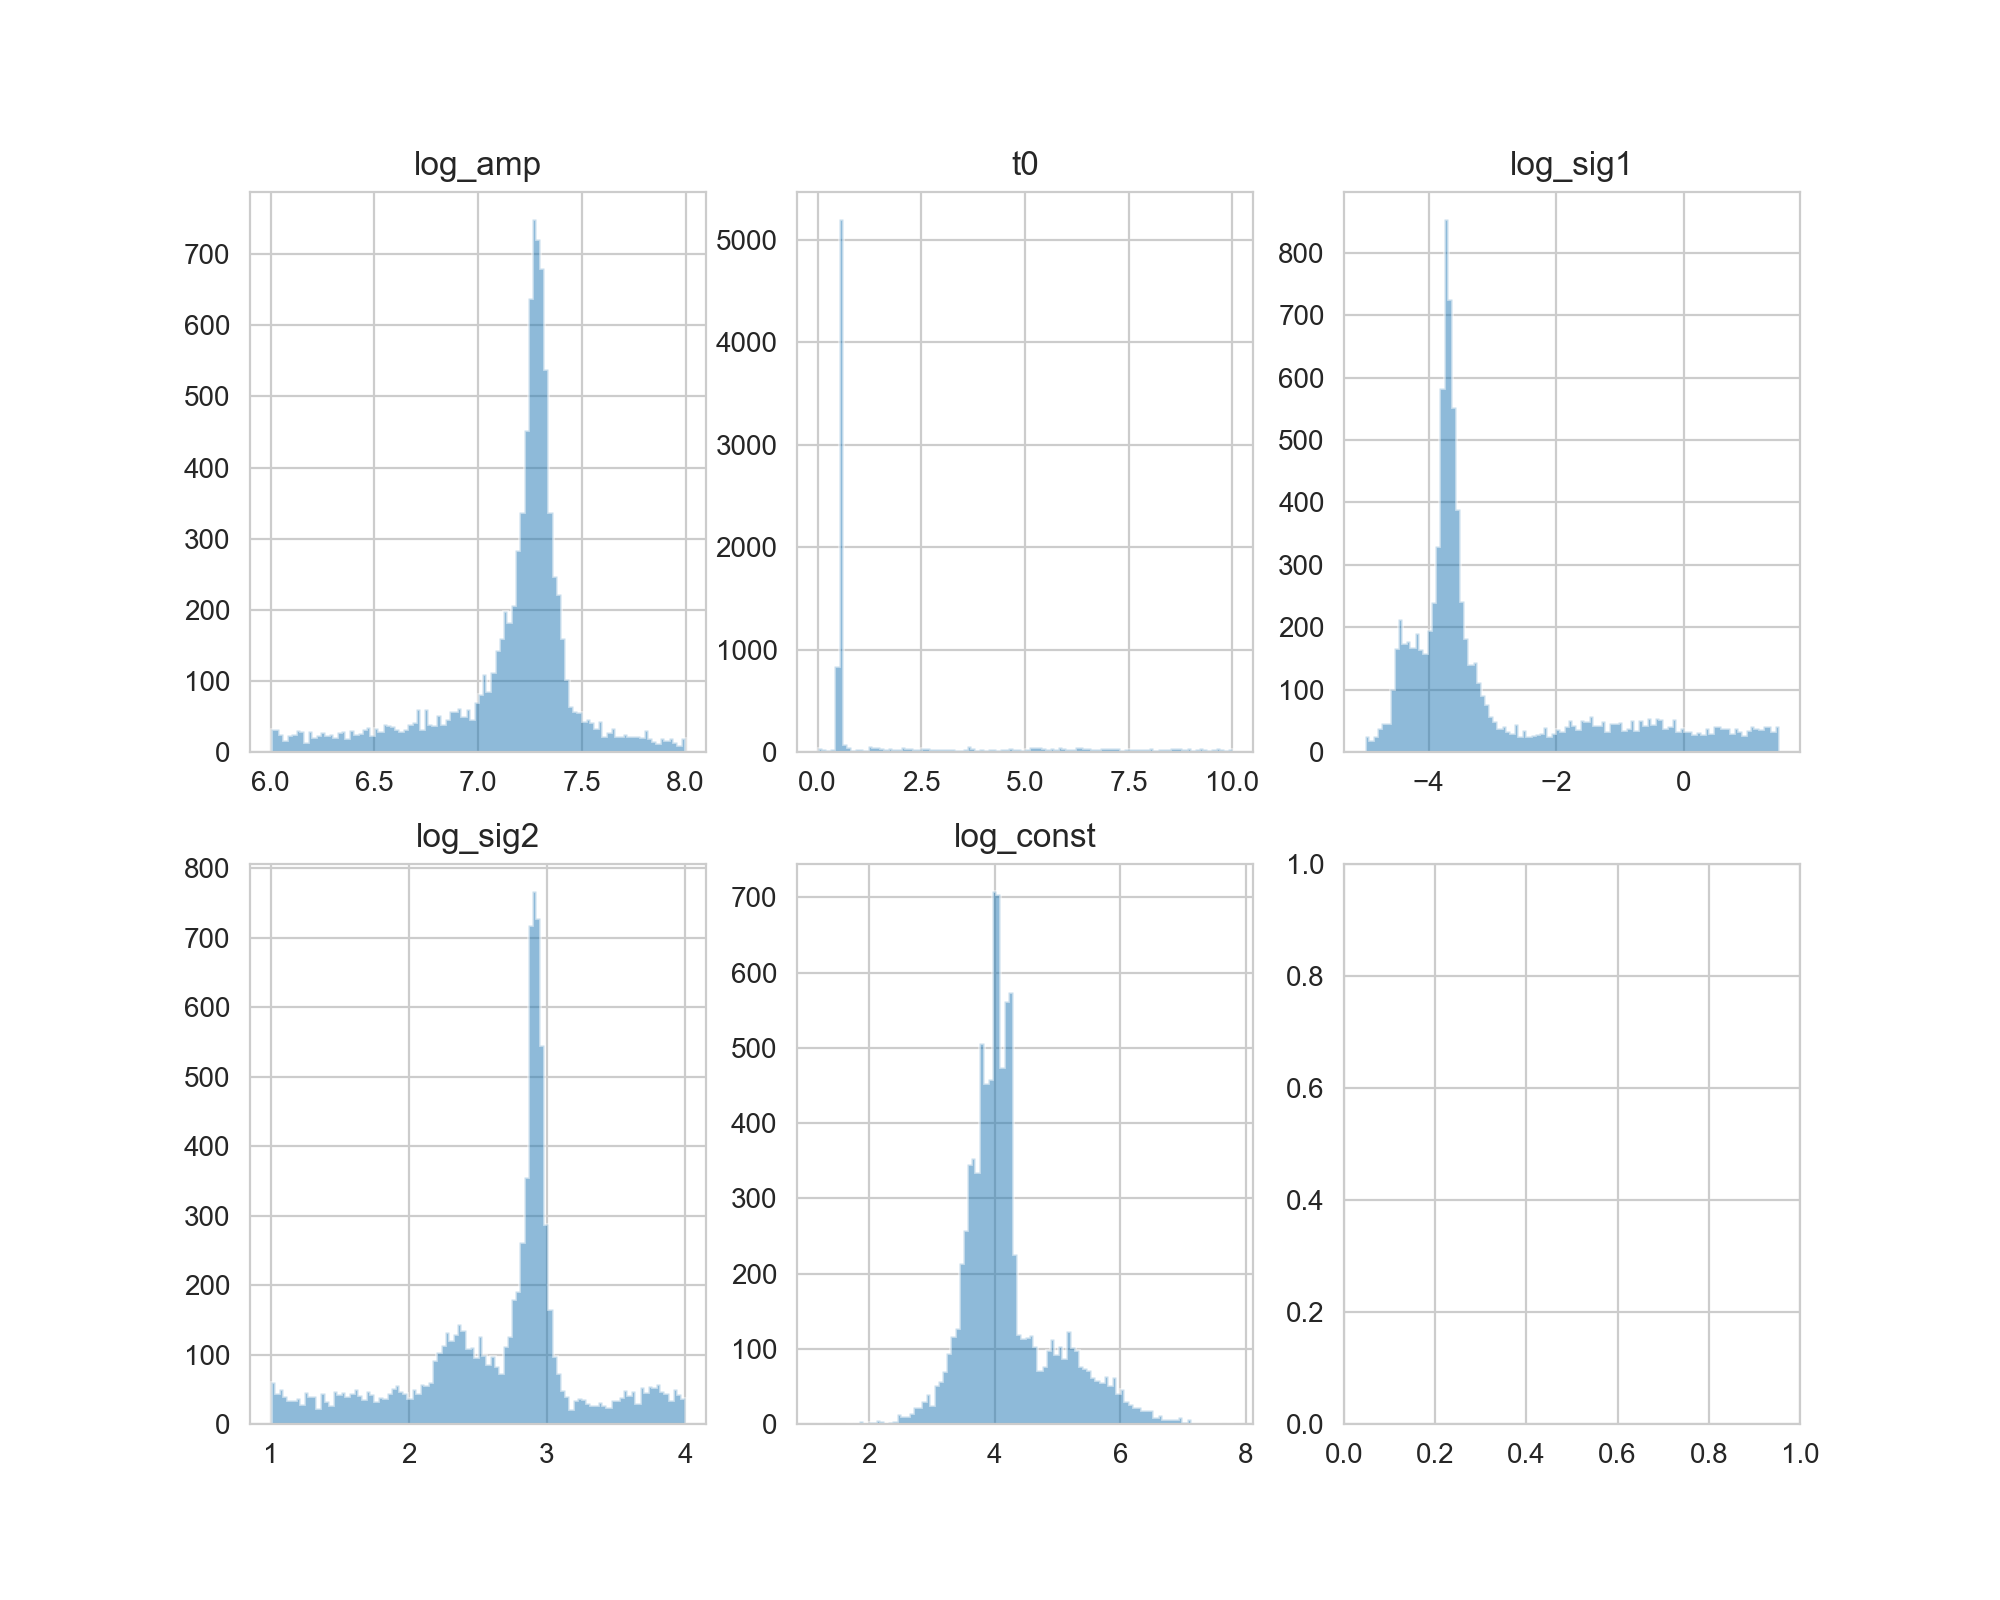

In [112]:
mean_var_names = ["log_amp", "t0", "log_sig1",
                  'log_sig2', "log_const"]

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = np.hstack(axes)

for i, vn in enumerate(mean_var_names):
    samp = samples_qpo[vn].block_until_ready()  
    axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    #axes[i].axvline(mean_params_true[i], lw=2, color="red")

<IPython.core.display.Javascript object>


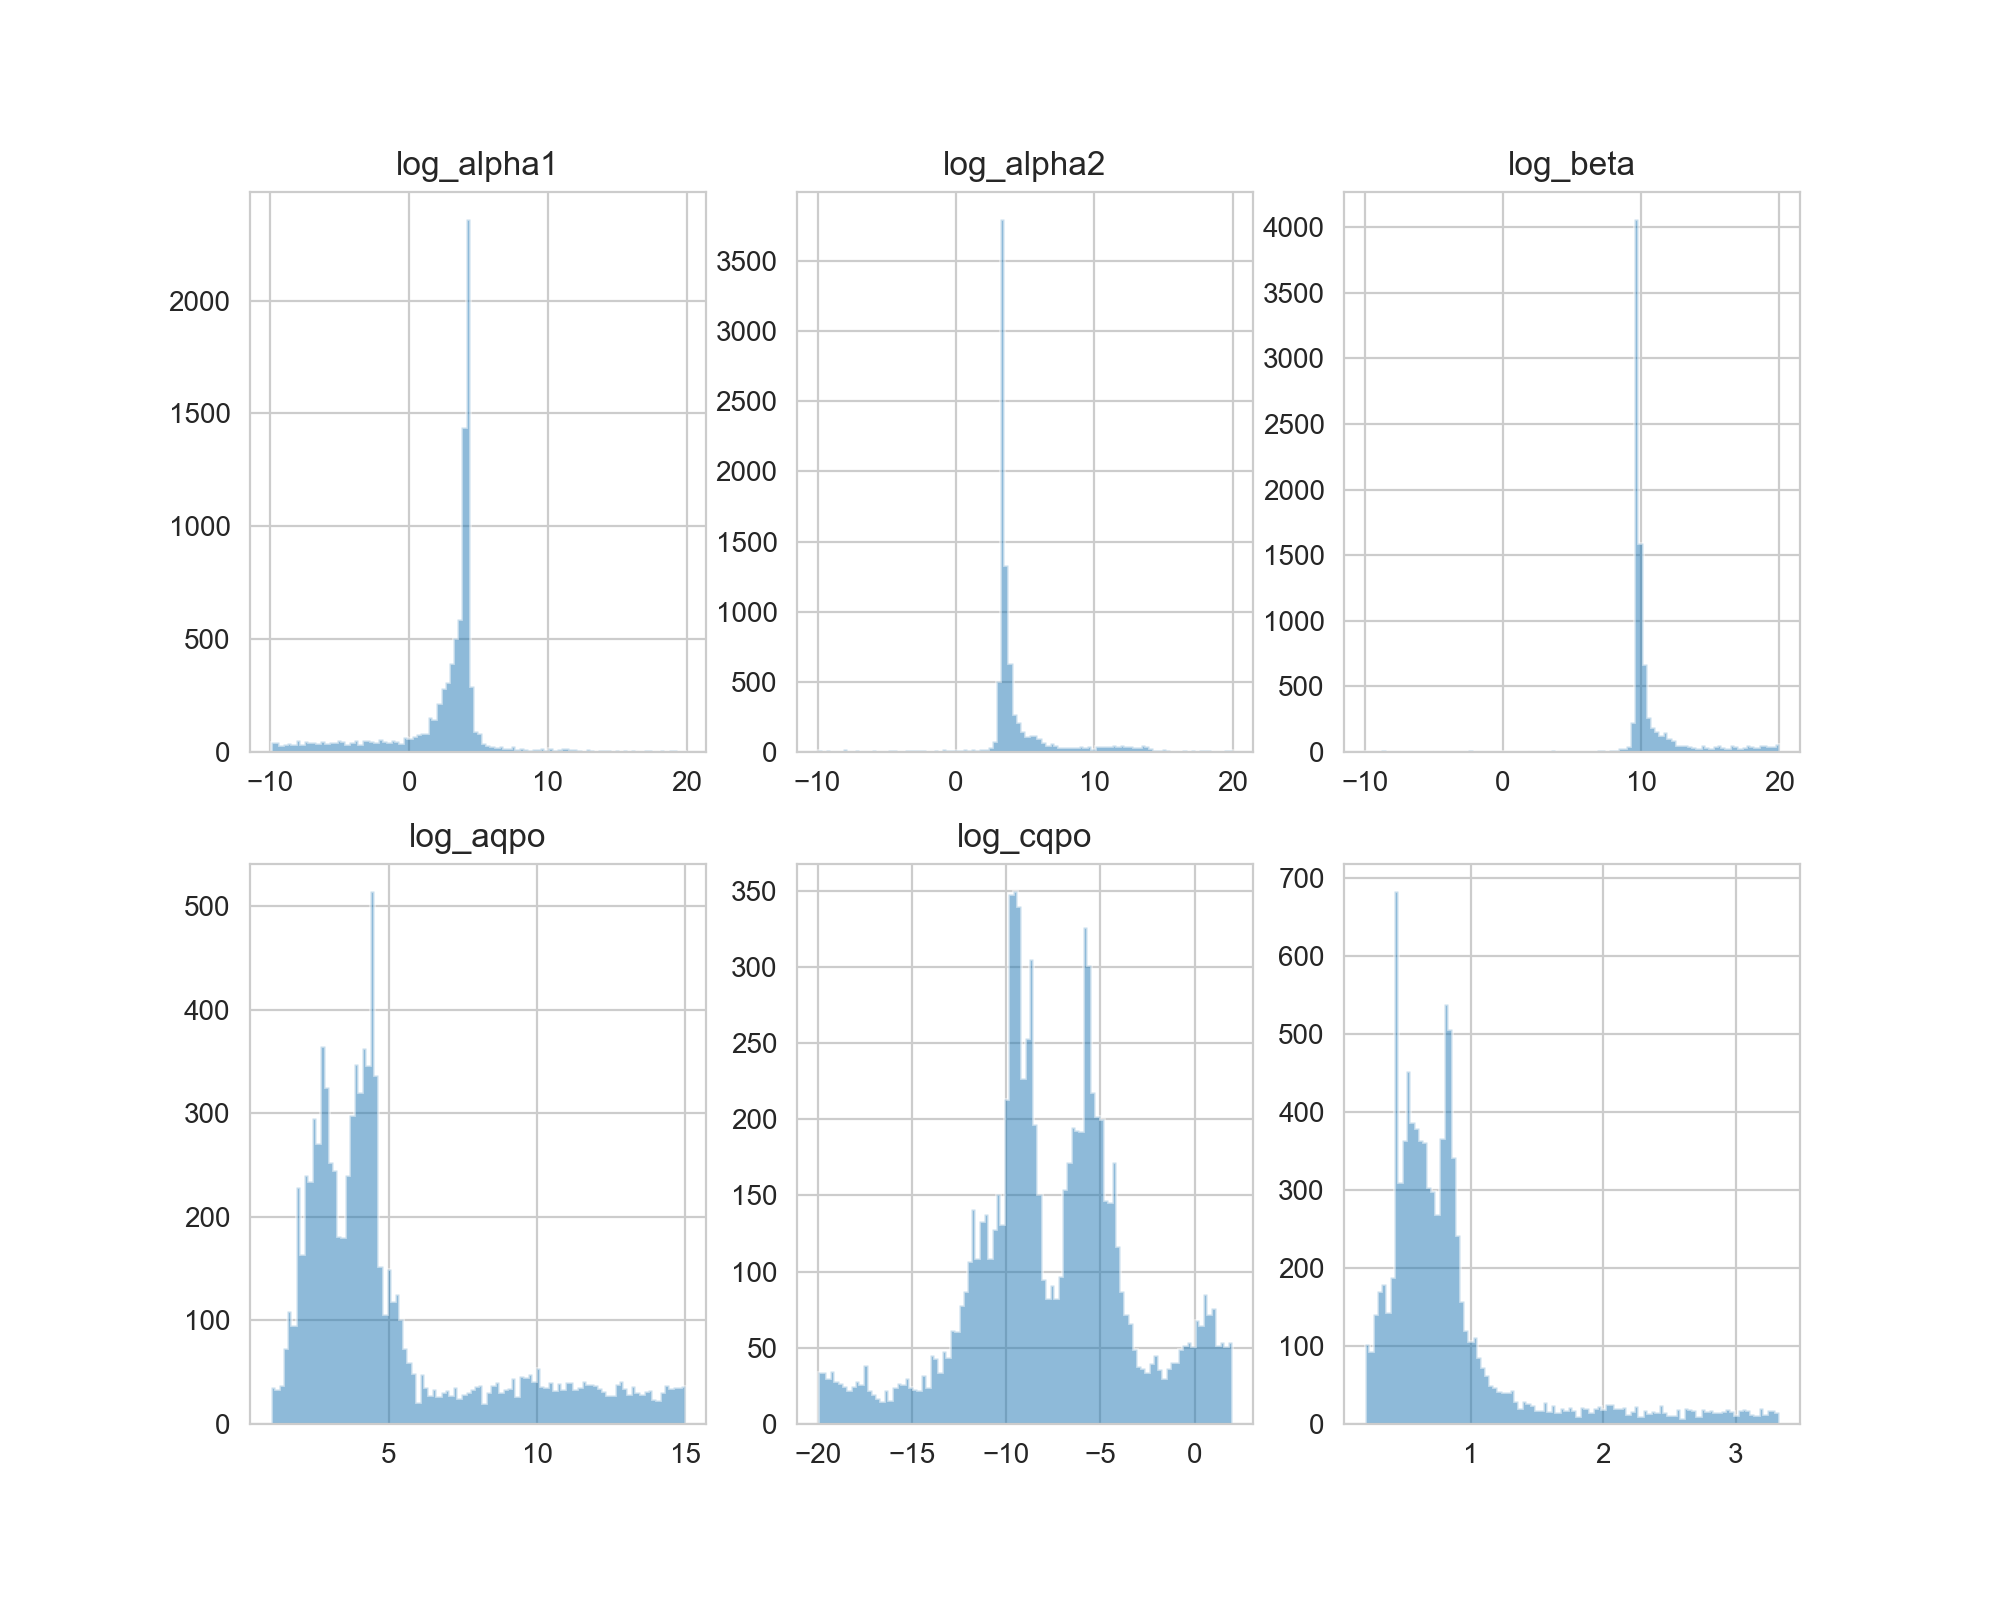

In [113]:
kernel_var_names = ["log_alpha1", "log_alpha2",
                    "log_beta", "log_aqpo", 
                    "log_cqpo", "log_freq"]


fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = np.hstack(axes)

for i, vn in enumerate(kernel_var_names):

    samp = samples_qpo[vn].block_until_ready()  
    if vn == "log_freq":
        axes[i].hist(1./jnp.exp(samp), bins=100, histtype="stepfilled", alpha=0.5)
    else:
        axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
        axes[i].set_title(vn)
    #axes[i].axvline(np.log(kernel_params_true[i]), lw=2, color="red")

In [114]:
def lorentzian(freq, amp, f0, fwhm):
    """
    A Lorentzian function (Cauchy distribution)
    
    Parameters
    ----------
    freq : numpy.ndarray
        An array of frequencies for which to 
        compute the Lorentzian
        
    amp : float
        The amplitude of the Lorentzian
        
    f0 : float
        The centroid frequency of the Lorentzian
        
    fwhm : float
        The full-width at half-maximum of the 
        Lorentzian
        
    Returns
    -------
    lor : numpy.ndarray
        The values of the Lorentzian for the 
        given parameters and frequency array
    
    """
    num = amp * fwhm**2.
    denom = fwhm**2. + (freq - f0)**2.0
    
    return num/denom   

<IPython.core.display.Javascript object>


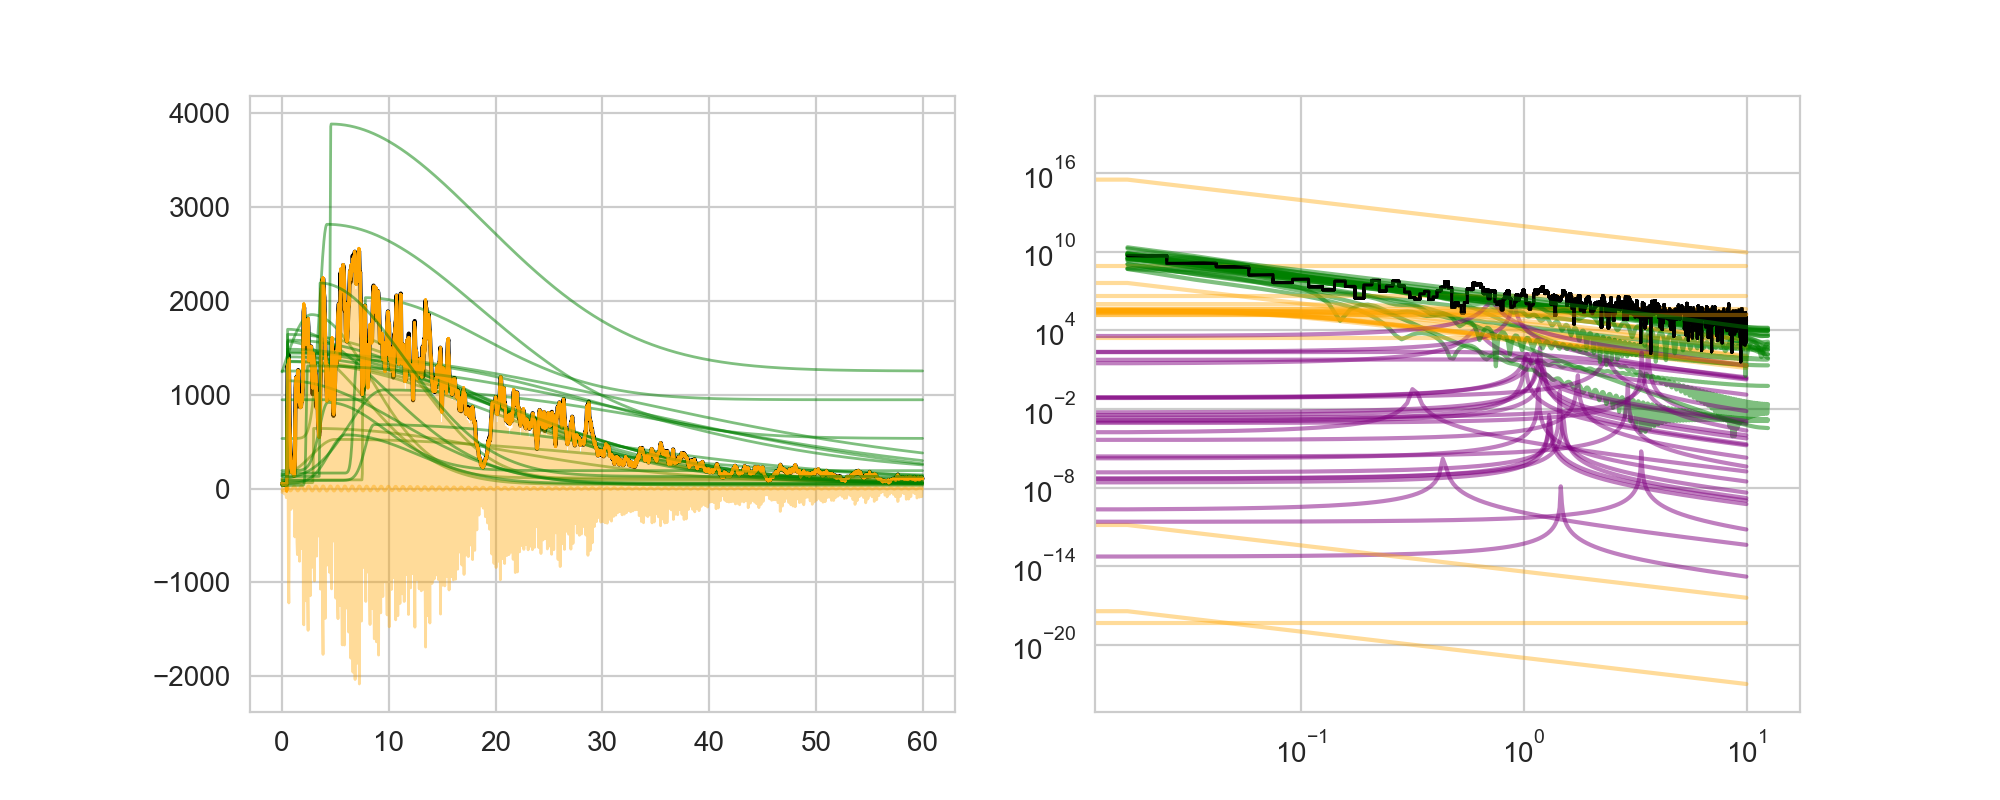

In [115]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc_na.time[:npoints], lc_na.counts[:npoints], color="black")

np.random.seed(1000)
nsims = 25 # number of simulated light curves / PSDs
nsamples = samples_qpo["log_alpha1"].shape[0]
idx_all = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nsims, replace=False)

# time array for the posterior predictive examples
tpost = np.linspace(0.0, lc_na.time[-1], 1500)
dt_post = tpost[1] - tpost[0]

# frequencies for the PSD
freq = np.fft.fftfreq(lc_na.n, d=lc_na.dt)
freq = freq[:int(lc_na.n/2)]

# calculate periodogram for comparison:
ps_na = Powerspectrum(lc_na, norm="abs")

for idx in idx_all:
    # mean parameters
    params = [samples_qpo["log_amp"][idx],
              samples_qpo["t0"][idx],
              samples_qpo["log_sig1"][idx],
              samples_qpo["log_sig2"][idx],
              samples_qpo["log_const"][idx]]
    
    mean_post = skewgaussian(tpost, params)
    
    # kernel parameters
    alpha_post = [jnp.exp(samples_qpo["log_alpha1"][idx]),
             jnp.exp(samples_qpo["log_alpha2"][idx])]
    
    beta_post = jnp.exp(samples_qpo["log_beta"][idx])
    
    kernel_carma = CARMA.init(alpha=alpha_post, 
                        beta=beta_post)
    
    
    aqpo_post = jnp.exp(samples_qpo["log_aqpo"][idx])
    cqpo_post = jnp.exp(samples_qpo["log_cqpo"][idx])
    freq_post = jnp.exp(samples_qpo['log_freq'][idx])
    
    # QPO kernel
    kernel_qpo = kernels.quasisep.Celerite(
            a=aqpo_post,
            b=0.0,
            c=cqpo_post,
            d=2 * jnp.pi * freq_post
        )
    
    # add kernels together
    kernel_post = kernel_carma + kernel_qpo
    
    gp = GaussianProcess(kernel_post, lc_na.time[:npoints], diag=0.01)

    _, cond = gp.condition(lc_na.counts[:npoints], tpost, include_mean=True)

    ax1.plot(tpost, cond.loc, lw=1, color="orange", alpha=0.4)
    ax1.plot(tpost, mean_post, lw=1, color="green", alpha=0.5)
    
    # PSD of the CARMA process
    psd_carma = power_spectrum(freq, alpha_post, ma_coefs=[beta_post])
    psd_lor = lorentzian(freq, aqpo_post, freq_post, cqpo_post)
    
    ps_mean = Powerspectrum(Lightcurve(tpost, mean_post, dt=dt_post, skip_checks=True), norm="abs")
    
    ax2.loglog(ps_na.freq, ps_na.power, lw=1, color="black", ds="steps-mid")
    ax2.loglog(freq, psd_carma, color="orange", alpha=0.4)
    ax2.loglog(ps_mean.freq, ps_mean.power, color="green", alpha=0.5)
    ax2.loglog(freq, psd_lor, color="purple", alpha=0.5)


I guess that's fine?

## BGO Data

Let's do the same for the BGO data

In [116]:
bgo_filename = "bn230307656_b1_mete.sav"

data = scipy.io.readsav(datadir+bgo_filename)
data

{'tte_b1_time': array([6.99896627e+08, 6.99896627e+08, 6.99896627e+08, ...,
        6.99896772e+08, 6.99896772e+08, 6.99896772e+08], dtype='>f8'),
 'b1_barytime': array([6.99896606e+08, 6.99896606e+08, 6.99896606e+08, ...,
        6.99896751e+08, 6.99896751e+08, 6.99896751e+08], dtype='>f8'),
 'btime': 699896651.671248}

In [117]:
barytime = np.array(data["b1_barytime"], dtype=float)
#counts = np.array(data["counts"], dtype=float)

trigtime = data["btime"]

barytime -= trigtime -21

In [118]:
np.log(np.max(lc_na.counts))

7.834788107388195

INFO[2023-10-13 13:07:11,772]: make_lightcurve: tseg: 144.99639451503754
INFO[2023-10-13 13:07:11,773]: make_lightcurve: timebin:  2899


4569.8


<IPython.core.display.Javascript object>


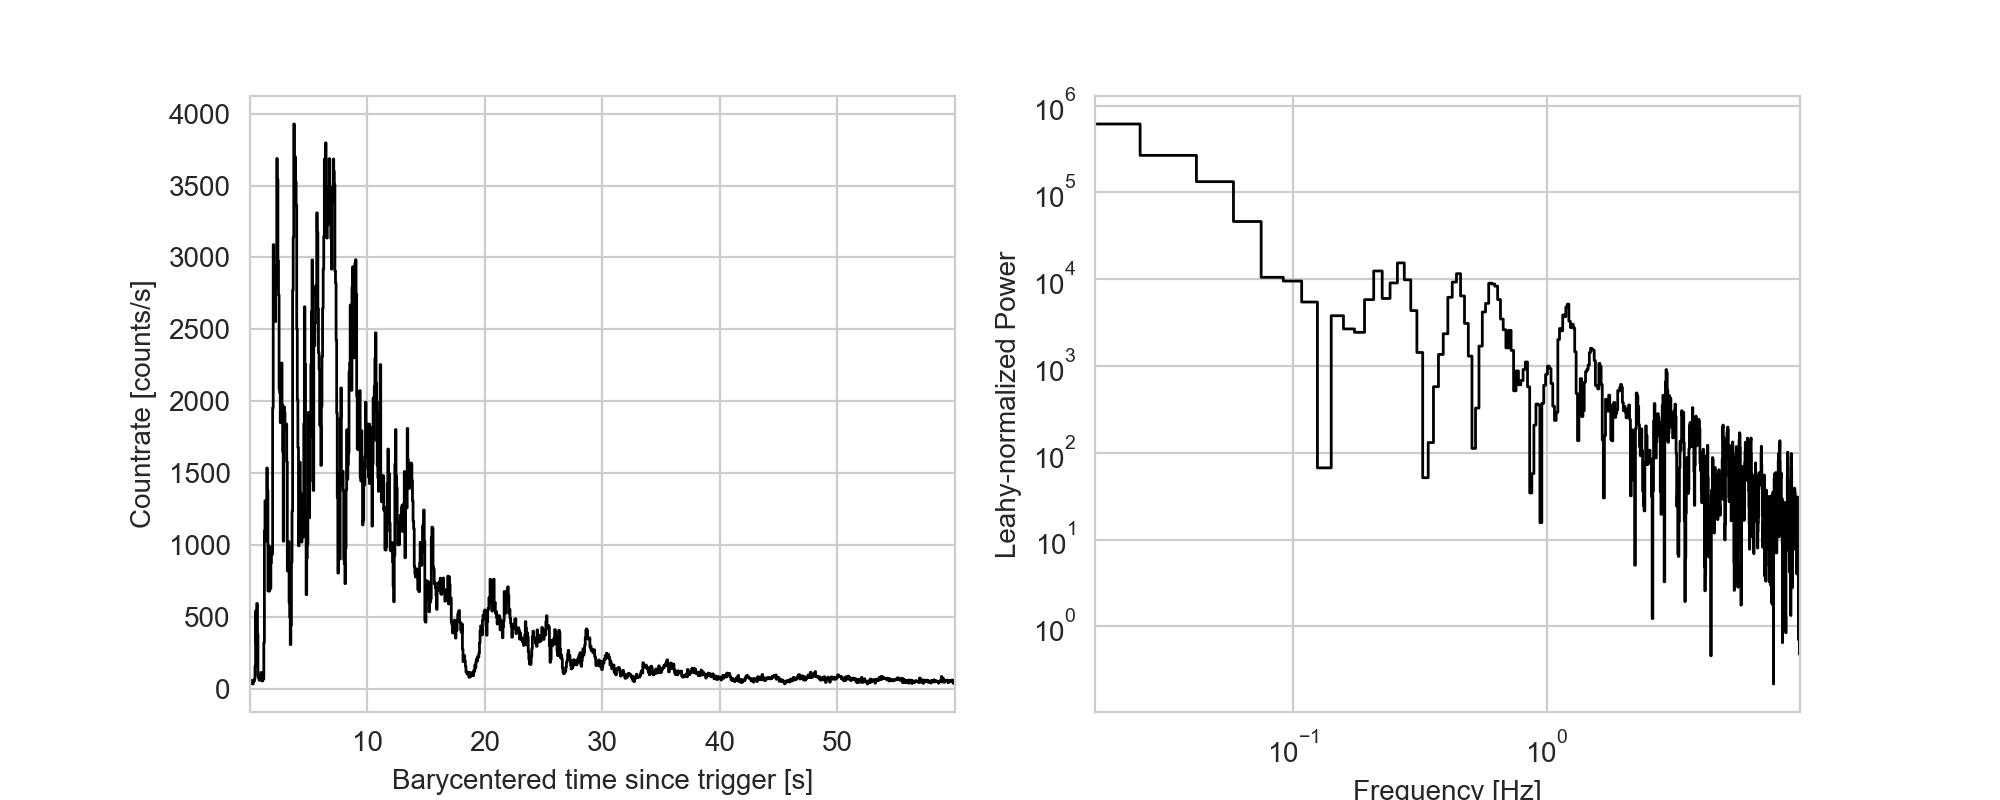

Text(0, 0.5, 'Leahy-normalized Power')

In [119]:
lc_bgo = Lightcurve.make_lightcurve(barytime, dt=lc.dt)

# calculate background flux
mean_bkg = np.mean(counts[-100:])
print(mean_bkg)

minind = lc_bgo.time.searchsorted(0.0)
maxind = lc_bgo.time.searchsorted(60.0)
lc_bgo = lc_bgo.truncate(start=minind, stop=maxind, method="index")

# calculate periodogram for comparison:
ps_bgo = Powerspectrum(lc_bgo, norm="leahy")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc_bgo.time, lc_bgo.counts, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc_bgo.time[0], lc_bgo.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps_bgo.freq, ps_bgo.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps_bgo.freq[0], ps_bgo.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

In [150]:
np.log(np.max(lc_bgo.counts))

8.275885669474356

In [151]:
mean_bkg = np.log(np.mean(lc_bgo.counts[-100:]))

def carma21_fermi_bgo(t, y=None):

    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(7, 9.0))
    t0 = numpyro.sample("t0", dist.Uniform(0.0, 10))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-5, 1.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 4))
    log_const = numpyro.sample("log_const", dist.Normal(mean_bkg, mean_bkg/5))

    params = [log_amp, t0, log_sig1,log_sig2, log_const]
    
    mean = skewgaussian(t, params)
    
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-10, 20))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-10, 20))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(-10, 20))
        
    kernel = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2)], 
                        beta=[jnp.exp(log_beta)])
    
    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
        
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)

In [152]:
npoints = len(lc_bgo.time)
ns_bgo = NestedSampler(carma21_fermi_bgo)
ns_bgo.run(random.PRNGKey(200), lc_bgo.time, y=lc_bgo.counts)

In [153]:
import pickle
with open(datadir + "fermi_bgo_carma21_ns.pkl", "wb") as f:
    pickle.dump(ns_bgo, f)

In [154]:
#import pickle
#with open(datadir + "fermi_na_carma21_ns.pkl", "rb") as f:
#    ns_na = pickle.load(f)

In [155]:
samples, weights = ns_bgo.get_weighted_samples()

ns_bgo.print_summary()


--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 1319211
# samples: 7800
# slices: 168000.0
# slices / acceptance: 24.0
# likelihood evals / sample: 169.1
# likelihood evals / slice: 7.8
--------
logZ=-7850.95 +- 0.38
H=7900.0
ESS=663
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: 4.98 +- 0.12 | 4.82 / 4.98 / 5.13 | 4.99 | 4.99
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha2: 3.82 +- 0.1 | 3.69 / 3.82 / 3.95 | 3.81 | 3.81
--------
log_amp: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_amp: 7.727 +- 0.055 | 7.66 / 7.731 / 7.8 | 7.735 | 7.735
--------
log_beta: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta: 10.662 +- 0.08 | 10.569 / 10.658 / 10.768 | 10.646 | 10.646
--------
log_const: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_const: 4.02 +- 0.043 | 3.97 /

pred[116]: 517.0 +- 100.0 | 381.0 / 517.0 / 640.0 | 488.0 | 488.0
pred[117]: 213.0 +- 99.0 | 78.0 / 213.0 / 335.0 | 184.0 | 184.0
pred[118]: 59.0 +- 98.0 | -74.0 / 58.0 / 180.0 | 28.0 | 28.0
pred[119]: -265.0 +- 98.0 | -399.0 / -266.0 / -143.0 | -295.0 | -295.0
pred[120]: -329.0 +- 97.0 | -460.0 / -331.0 / -210.0 | -361.0 | -361.0
pred[121]: -528.0 +- 97.0 | -661.0 / -529.0 / -407.0 | -558.0 | -558.0
pred[122]: -167.0 +- 96.0 | -298.0 / -168.0 / -47.0 | -199.0 | -199.0
pred[123]: 202.0 +- 95.0 | 69.0 / 201.0 / 320.0 | 170.0 | 170.0
pred[124]: 532.0 +- 95.0 | 401.0 / 532.0 / 650.0 | 500.0 | 500.0
pred[125]: 808.0 +- 94.0 | 677.0 / 809.0 / 926.0 | 775.0 | 775.0
pred[126]: 1088.0 +- 94.0 | 957.0 / 1088.0 / 1204.0 | 1056.0 | 1056.0
pred[127]: 1474.0 +- 93.0 | 1348.0 / 1474.0 / 1589.0 | 1440.0 | 1440.0
pred[128]: 1324.0 +- 93.0 | 1188.0 / 1326.0 / 1438.0 | 1292.0 | 1292.0
pred[129]: 1565.0 +- 91.0 | 1440.0 / 1568.0 / 1676.0 | 1530.0 | 1530.0
pred[130]: 1148.0 +- 91.0 | 1017.0 / 1148.0 / 126

pred[354]: -90.0 +- 110.0 | -210.0 / -90.0 / 50.0 | -150.0 | -150.0
pred[355]: -70.0 +- 110.0 | -190.0 / -70.0 / 70.0 | -130.0 | -130.0
pred[356]: -60.0 +- 100.0 | -180.0 / -60.0 / 80.0 | -120.0 | -120.0
pred[357]: -130.0 +- 100.0 | -250.0 / -130.0 / 10.0 | -190.0 | -190.0
pred[358]: -130.0 +- 100.0 | -250.0 / -130.0 / 10.0 | -190.0 | -190.0
pred[359]: -180.0 +- 100.0 | -300.0 / -180.0 / -40.0 | -240.0 | -240.0
pred[360]: -190.0 +- 100.0 | -310.0 / -190.0 / -50.0 | -250.0 | -250.0
pred[361]: -130.0 +- 100.0 | -250.0 / -130.0 / 10.0 | -190.0 | -190.0
pred[362]: -290.0 +- 100.0 | -410.0 / -290.0 / -160.0 | -360.0 | -360.0
pred[363]: -380.0 +- 100.0 | -500.0 / -370.0 / -240.0 | -440.0 | -440.0
pred[364]: -360.0 +- 100.0 | -480.0 / -360.0 / -230.0 | -420.0 | -420.0
pred[365]: -330.0 +- 100.0 | -450.0 / -320.0 / -190.0 | -390.0 | -390.0
pred[366]: -360.0 +- 100.0 | -480.0 / -360.0 / -230.0 | -420.0 | -420.0
pred[367]: -390.0 +- 100.0 | -510.0 / -390.0 / -260.0 | -450.0 | -450.0
pred[368]: -

pred[588]: 122.0 +- 26.0 | 100.0 / 128.0 / 145.0 | 113.0 | 113.0
pred[589]: 74.0 +- 26.0 | 53.0 / 80.0 / 97.0 | 66.0 | 66.0
pred[590]: 71.0 +- 25.0 | 50.0 / 78.0 / 94.0 | 63.0 | 63.0
pred[591]: 92.0 +- 25.0 | 71.0 / 98.0 / 114.0 | 84.0 | 84.0
pred[592]: 96.0 +- 25.0 | 76.0 / 102.0 / 118.0 | 88.0 | 88.0
pred[593]: 98.0 +- 25.0 | 78.0 / 104.0 / 120.0 | 90.0 | 90.0
pred[594]: 112.0 +- 24.0 | 92.0 / 118.0 / 133.0 | 104.0 | 104.0
pred[595]: 72.0 +- 24.0 | 52.0 / 78.0 / 93.0 | 64.0 | 64.0
pred[596]: 69.0 +- 24.0 | 50.0 / 75.0 / 90.0 | 62.0 | 62.0
pred[597]: 103.0 +- 24.0 | 84.0 / 109.0 / 124.0 | 96.0 | 96.0
pred[598]: 94.0 +- 23.0 | 75.0 / 100.0 / 114.0 | 86.0 | 86.0
pred[599]: 48.0 +- 23.0 | 29.0 / 54.0 / 68.0 | 41.0 | 41.0
pred[600]: 71.0 +- 23.0 | 52.0 / 77.0 / 91.0 | 64.0 | 64.0
pred[601]: 103.0 +- 23.0 | 85.0 / 109.0 / 123.0 | 96.0 | 96.0
pred[602]: 94.0 +- 22.0 | 76.0 / 100.0 / 114.0 | 87.0 | 87.0
pred[603]: 117.0 +- 22.0 | 99.0 / 123.0 / 136.0 | 110.0 | 110.0
pred[604]: 126.0 +- 22.0 

pred[815]: 44.4 +- 2.9 | 41.2 / 44.7 / 47.3 | 42.2 | 42.2
pred[816]: 50.2 +- 2.9 | 47.0 / 50.5 / 53.1 | 48.0 | 48.0
pred[817]: 28.5 +- 2.9 | 25.3 / 28.8 / 31.4 | 26.3 | 26.3
pred[818]: 26.3 +- 2.9 | 23.1 / 26.6 / 29.1 | 24.1 | 24.1
pred[819]: 8.5 +- 2.9 | 5.3 / 8.7 / 11.3 | 6.2 | 6.2
pred[820]: 6.4 +- 2.9 | 3.2 / 6.7 / 9.2 | 4.1 | 4.1
pred[821]: 1.5 +- 2.9 | -1.7 / 1.8 / 4.4 | -0.7 | -0.7
pred[822]: 15.3 +- 2.8 | 12.1 / 15.6 / 18.1 | 13.1 | 13.1
pred[823]: 0.5 +- 2.8 | -2.7 / 0.8 / 3.4 | -1.7 | -1.7
pred[824]: 1.4 +- 2.8 | -1.8 / 1.7 / 4.2 | -0.8 | -0.8
pred[825]: -5.5 +- 2.8 | -8.7 / -5.1 / -2.7 | -7.7 | -7.7
pred[826]: 0.5 +- 2.8 | -2.7 / 0.8 / 3.2 | -1.8 | -1.8
pred[827]: 3.5 +- 2.8 | 0.4 / 3.9 / 6.3 | 1.3 | 1.3
pred[828]: 17.5 +- 2.8 | 14.4 / 17.9 / 20.3 | 15.3 | 15.3
pred[829]: 24.4 +- 2.8 | 21.2 / 24.8 / 27.1 | 22.2 | 22.2
pred[830]: 4.8 +- 2.8 | 1.6 / 5.2 / 7.5 | 2.6 | 2.6
pred[831]: 36.1 +- 2.8 | 33.0 / 36.5 / 38.9 | 33.9 | 33.9
pred[832]: -4.2 +- 2.7 | -7.4 / -3.8 / -1.5 | -6.

pred[1010]: 10.2 +- 2.4 | 7.4 / 10.4 / 13.0 | 7.9 | 7.9
pred[1011]: 0.2 +- 2.4 | -2.6 / 0.5 / 3.0 | -2.1 | -2.1
pred[1012]: 5.3 +- 2.4 | 2.5 / 5.5 / 8.1 | 3.0 | 3.0
pred[1013]: 27.0 +- 2.4 | 24.2 / 27.3 / 29.8 | 24.7 | 24.7
pred[1014]: 4.4 +- 2.4 | 1.5 / 4.6 / 7.2 | 2.0 | 2.0
pred[1015]: 23.1 +- 2.4 | 20.3 / 23.4 / 25.9 | 20.8 | 20.8
pred[1016]: 27.2 +- 2.4 | 24.4 / 27.4 / 29.9 | 24.8 | 24.8
pred[1017]: 20.3 +- 2.4 | 17.5 / 20.6 / 23.1 | 18.0 | 18.0
pred[1018]: 33.0 +- 2.4 | 30.2 / 33.3 / 35.8 | 30.7 | 30.7
pred[1019]: 13.4 +- 2.4 | 10.5 / 13.6 / 16.2 | 11.0 | 11.0
pred[1020]: 26.1 +- 2.4 | 23.3 / 26.3 / 28.8 | 23.7 | 23.7
pred[1021]: 11.3 +- 2.4 | 8.4 / 11.5 / 14.1 | 8.9 | 8.9
pred[1022]: 5.2 +- 2.4 | 2.4 / 5.5 / 8.0 | 2.9 | 2.9
pred[1023]: 3.2 +- 2.4 | 0.4 / 3.5 / 6.0 | 0.9 | 0.9
pred[1024]: 10.2 +- 2.4 | 7.4 / 10.5 / 13.0 | 7.9 | 7.9
pred[1025]: 16.2 +- 2.4 | 13.4 / 16.5 / 19.0 | 13.9 | 13.9
pred[1026]: 18.2 +- 2.4 | 15.4 / 18.5 / 21.0 | 15.9 | 15.9
pred[1027]: 19.2 +- 2.4 | 16.4 / 

<IPython.core.display.Javascript object>


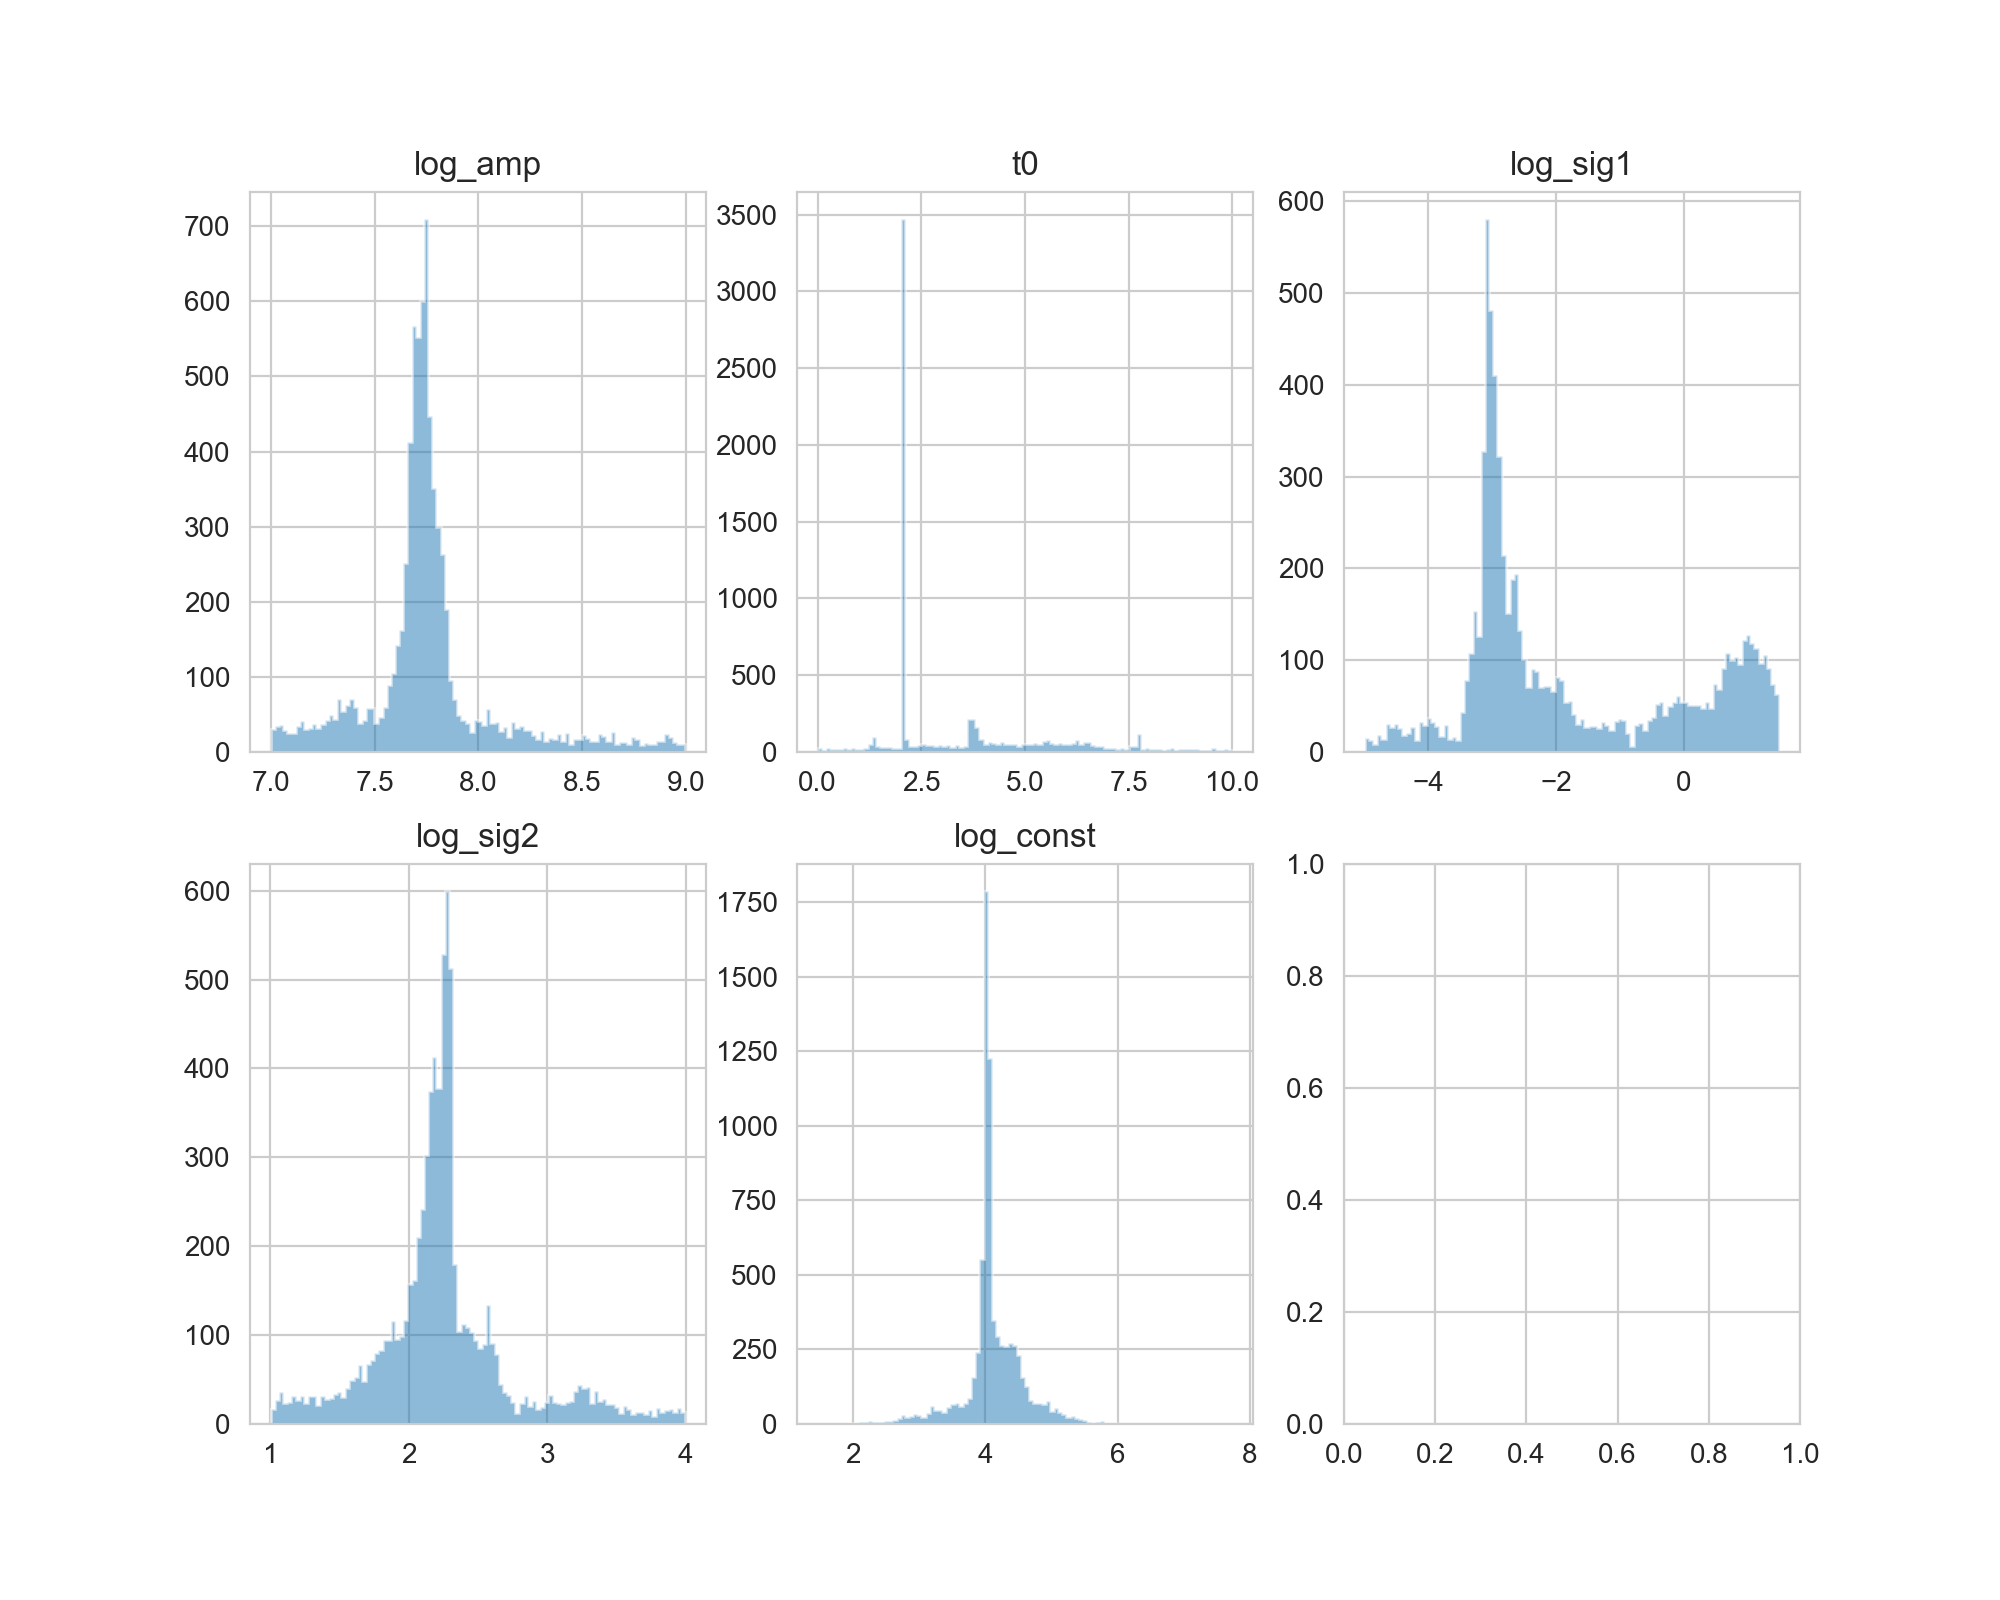

In [156]:
mean_var_names = ["log_amp", "t0", "log_sig1",
                  'log_sig2', "log_const"]

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = np.hstack(axes)

for i, vn in enumerate(mean_var_names):
    samp = samples[vn].block_until_ready()  
    axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    #axes[i].axvline(mean_params_true[i], lw=2, color="red")

<IPython.core.display.Javascript object>


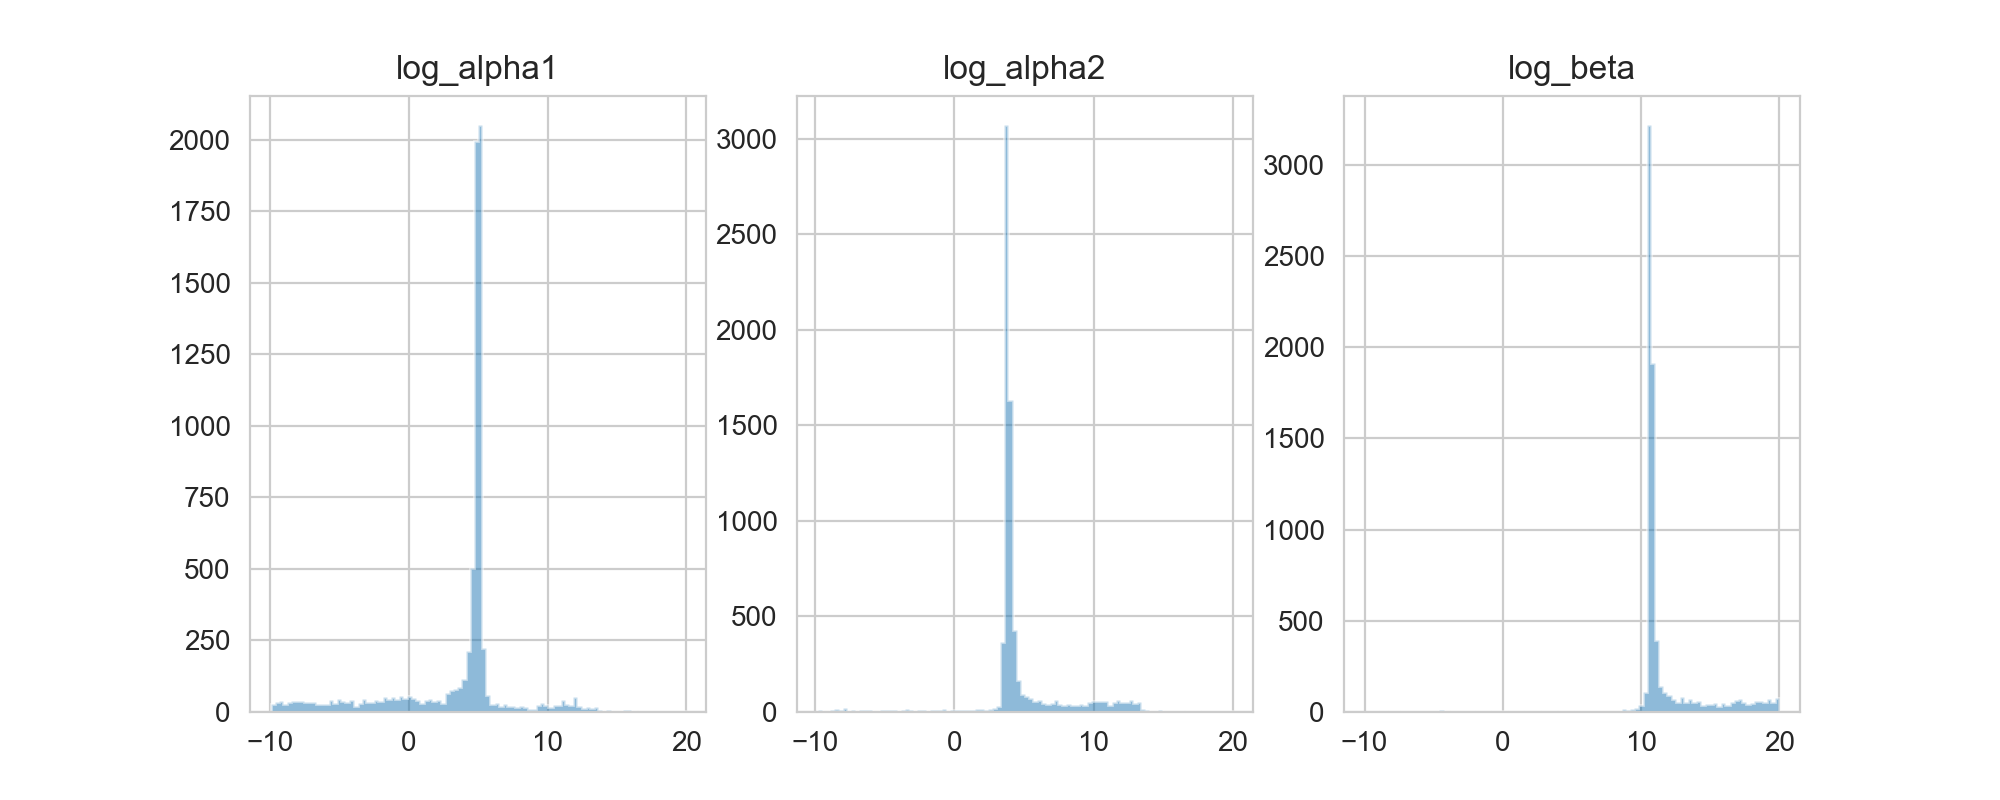

In [157]:
kernel_var_names = ["log_alpha1", "log_alpha2", "log_beta"]


fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes = np.hstack(axes)

for i, vn in enumerate(kernel_var_names):
    samp = samples[vn].block_until_ready()  
    axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    #axes[i].axvline(np.log(kernel_params_true[i]), lw=2, color="red")

Let's include a function to compute the PSD:

In [158]:
npoints = len(lc_bgo.counts)

<IPython.core.display.Javascript object>


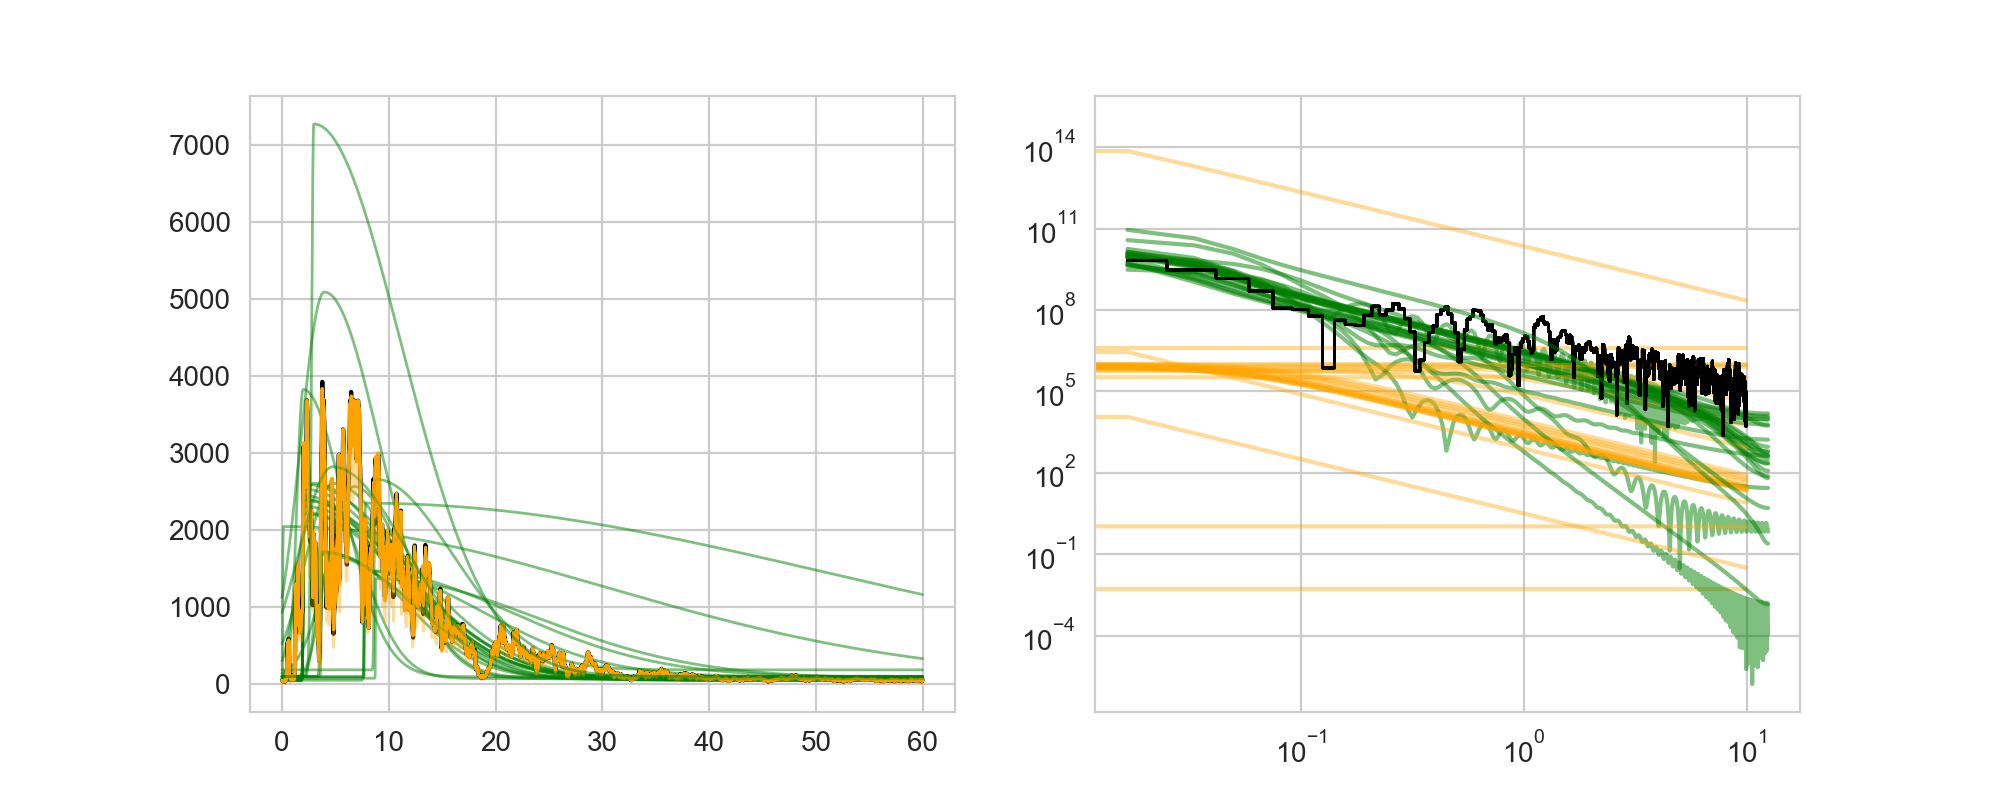

In [159]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc_bgo.time[:npoints], lc_bgo.counts[:npoints], color="black")

np.random.seed(1000)
nsims = 25 # number of simulated light curves / PSDs
nsamples = samples["log_alpha1"].shape[0]
idx_all = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nsims, replace=False)

# time array for the posterior predictive examples
tpost = np.linspace(0.0, lc_bgo.time[-1], 1500)
dt_post = tpost[1] - tpost[0]

# frequencies for the PSD
freq = np.fft.fftfreq(lc_bgo.n, d=lc_bgo.dt)
freq = freq[:int(lc_bgo.n/2)]
# calculate periodogram for comparison:
ps_bgo = Powerspectrum(lc_bgo, norm="abs")

for idx in idx_all:
    # mean parameters
    params = [samples["log_amp"][idx],
              samples["t0"][idx],
              samples["log_sig1"][idx],
              samples["log_sig2"][idx],
              samples["log_const"][idx]]
    
    mean_post = skewgaussian(tpost, params)
    
    # kernel parameters
    alpha_post = [jnp.exp(samples["log_alpha1"][idx]),
             jnp.exp(samples["log_alpha2"][idx])]
    
    beta_post = jnp.exp(samples["log_beta"][idx])

    
    kernel_post = CARMA.init(alpha=alpha_post, 
                        beta=beta_post)
    
    gp = GaussianProcess(kernel_post, lc_bgo.time[:npoints], diag=0.01)

    _, cond = gp.condition(lc_bgo.counts[:npoints], tpost, include_mean=True)

    ax1.plot(tpost, cond.loc, lw=1, color="orange", alpha=0.4)
    ax1.plot(tpost, mean_post, lw=1, color="green", alpha=0.5)
    
    psd = power_spectrum(freq, alpha_post, ma_coefs=[beta_post])
    
    ps_mean = Powerspectrum(Lightcurve(tpost, mean_post, dt=dt_post, skip_checks=True), norm="abs")
    
    ax2.loglog(ps_bgo.freq, ps_bgo.power, lw=1, color="black", ds="steps-mid")
    ax2.loglog(freq, psd, color="orange", alpha=0.4)
    ax2.loglog(ps_mean.freq, ps_mean.power, color="green", alpha=0.5)


### Model with a QPO

In [180]:
mean_bkg = np.log(np.mean(lc_bgo.counts[-100:]))

def carma21_fermi_bgo_with_qpo(t, y=None):

    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(7, 9.0))
    t0 = numpyro.sample("t0", dist.Uniform(0.0, 10))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-5, 1.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 4))
    log_const = numpyro.sample("log_const", dist.Normal(mean_bkg, mean_bkg/5))

    params = [log_amp, t0, log_sig1,log_sig2, log_const]
    
    mean = skewgaussian(t, params)
    
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-10, 20))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-10, 20))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(-10, 20))
    
    kernel_carma = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2)], 
                        beta=[jnp.exp(log_beta)])
        
    # QPO kernel parameters
    log_aqpo = numpyro.sample("log_aqpo", dist.Uniform(5, 15))
    log_cqpo = numpyro.sample("log_cqpo", dist.Uniform(-20, 2))
    log_freq = numpyro.sample("log_freq", dist.Uniform(np.log(0.3), np.log(5.0)))
    
    # QPO kernel
    kernel_qpo = kernels.quasisep.Celerite(
            a=jnp.exp(log_aqpo),
            b=0.0,
            c=jnp.exp(log_cqpo),
            d=2 * jnp.pi * jnp.exp(log_freq),
        )
    
    # add kernels together
    kernel = kernel_carma + kernel_qpo
    
    # gaussian process
    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
    
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)

Let's sample this model, too:

In [189]:
npoints = lc_bgo.n
ns_qpo = NestedSampler(carma21_fermi_bgo_with_qpo, constructor_kwargs={"max_samples":10000})
ns_qpo.run(random.PRNGKey(1200), lc_bgo.time[:npoints], y=lc_bgo.counts[:npoints])

In [190]:
import pickle
with open(datadir + "fermi_bgo_carma21_qpo_ns.pkl", "wb") as f:
    pickle.dump(ns_qpo, f)

In [191]:
samples_qpo, weights_qpo = ns_qpo.get_weighted_samples()

ns_qpo.print_summary()


--------
Termination Conditions:
Reached max samples
Small remaining evidence
--------
# likelihood evals: 1998566
# samples: 10000
# slices: 293700.0
# slices / acceptance: 33.0
# likelihood evals / sample: 199.9
# likelihood evals / slice: 6.8
--------
logZ=-7852.37 +- 0.33
H=7900.0
ESS=923
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: 4.94 +- 0.14 | 4.76 / 4.95 / 5.11 | 5.07 | 5.07
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha2: 3.82 +- 0.11 | 3.68 / 3.82 / 3.98 | 3.9 | 3.9
--------
log_amp: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_amp: 7.59 +- 0.048 | 7.526 / 7.593 / 7.648 | 7.717 | 7.717
--------
log_aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_aqpo: 7.39 +- 0.37 | 6.92 / 7.39 / 7.95 | 7.57 | 7.57
--------
log_beta: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_beta: 10.66 +- 0.086

pred[114]: 1290.0 +- 86.0 | 1179.0 / 1288.0 / 1400.0 | 1061.0 | 1061.0
pred[115]: 1203.0 +- 85.0 | 1090.0 / 1201.0 / 1312.0 | 974.0 | 974.0
pred[116]: 727.0 +- 85.0 | 618.0 / 725.0 / 836.0 | 498.0 | 498.0
pred[117]: 421.0 +- 85.0 | 312.0 / 420.0 / 530.0 | 194.0 | 194.0
pred[118]: 265.0 +- 85.0 | 156.0 / 263.0 / 375.0 | 40.0 | 40.0
pred[119]: -59.0 +- 85.0 | -168.0 / -62.0 / 49.0 | -286.0 | -286.0
pred[120]: -126.0 +- 84.0 | -233.0 / -128.0 / -17.0 | -348.0 | -348.0
pred[121]: -325.0 +- 84.0 | -433.0 / -327.0 / -218.0 | -550.0 | -550.0
pred[122]: 34.0 +- 84.0 | -75.0 / 32.0 / 142.0 | -187.0 | -187.0
pred[123]: 401.0 +- 84.0 | 292.0 / 399.0 / 508.0 | 179.0 | 179.0
pred[124]: 730.0 +- 84.0 | 621.0 / 729.0 / 838.0 | 510.0 | 510.0
pred[125]: 1004.0 +- 83.0 | 895.0 / 1002.0 / 1112.0 | 785.0 | 785.0
pred[126]: 1283.0 +- 83.0 | 1178.0 / 1281.0 / 1391.0 | 1063.0 | 1063.0
pred[127]: 1667.0 +- 83.0 | 1558.0 / 1667.0 / 1774.0 | 1453.0 | 1453.0
pred[128]: 1517.0 +- 83.0 | 1411.0 / 1514.0 / 1625.0 |

pred[368]: -551.0 +- 75.0 | -643.0 / -549.0 / -458.0 | -517.0 | -517.0
pred[369]: -545.0 +- 75.0 | -637.0 / -543.0 / -453.0 | -510.0 | -510.0
pred[370]: -557.0 +- 75.0 | -648.0 / -554.0 / -464.0 | -521.0 | -521.0
pred[371]: -541.0 +- 75.0 | -632.0 / -539.0 / -448.0 | -505.0 | -505.0
pred[372]: -551.0 +- 75.0 | -643.0 / -549.0 / -459.0 | -515.0 | -515.0
pred[373]: -566.0 +- 75.0 | -657.0 / -564.0 / -473.0 | -529.0 | -529.0
pred[374]: -528.0 +- 75.0 | -620.0 / -526.0 / -436.0 | -491.0 | -491.0
pred[375]: -554.0 +- 74.0 | -646.0 / -553.0 / -462.0 | -517.0 | -517.0
pred[376]: -530.0 +- 74.0 | -621.0 / -528.0 / -438.0 | -492.0 | -492.0
pred[377]: -535.0 +- 74.0 | -627.0 / -534.0 / -444.0 | -497.0 | -497.0
pred[378]: -517.0 +- 74.0 | -609.0 / -516.0 / -426.0 | -479.0 | -479.0
pred[379]: -508.0 +- 74.0 | -600.0 / -507.0 / -417.0 | -470.0 | -470.0
pred[380]: -526.0 +- 74.0 | -617.0 / -525.0 / -435.0 | -487.0 | -487.0
pred[381]: -487.0 +- 74.0 | -579.0 / -486.0 / -397.0 | -448.0 | -448.0
pred[3

pred[574]: 238.0 +- 30.0 | 201.0 / 243.0 / 271.0 | 266.0 | 266.0
pred[575]: 184.0 +- 30.0 | 148.0 / 189.0 / 217.0 | 212.0 | 212.0
pred[576]: 184.0 +- 30.0 | 147.0 / 188.0 / 216.0 | 211.0 | 211.0
pred[577]: 187.0 +- 30.0 | 150.0 / 191.0 / 219.0 | 214.0 | 214.0
pred[578]: 193.0 +- 29.0 | 157.0 / 197.0 / 225.0 | 219.0 | 219.0
pred[579]: 130.0 +- 29.0 | 94.0 / 135.0 / 162.0 | 157.0 | 157.0
pred[580]: 137.0 +- 29.0 | 101.0 / 141.0 / 169.0 | 163.0 | 163.0
pred[581]: 108.0 +- 29.0 | 73.0 / 113.0 / 140.0 | 135.0 | 135.0
pred[582]: 117.0 +- 28.0 | 82.0 / 122.0 / 149.0 | 143.0 | 143.0
pred[583]: 114.0 +- 28.0 | 79.0 / 118.0 / 145.0 | 140.0 | 140.0
pred[584]: 96.0 +- 28.0 | 61.0 / 100.0 / 126.0 | 121.0 | 121.0
pred[585]: 106.0 +- 28.0 | 72.0 / 110.0 / 137.0 | 132.0 | 132.0
pred[586]: 117.0 +- 28.0 | 83.0 / 121.0 / 147.0 | 143.0 | 143.0
pred[587]: 75.0 +- 27.0 | 40.0 / 78.0 / 104.0 | 99.0 | 99.0
pred[588]: 61.0 +- 27.0 | 27.0 / 65.0 / 91.0 | 86.0 | 86.0
pred[589]: 14.0 +- 27.0 | -20.0 / 18.0 / 43.

pred[805]: 7.5 +- 7.8 | -2.3 / 8.4 / 15.6 | 9.9 | 9.9
pred[806]: -12.2 +- 7.8 | -22.0 / -11.3 / -4.1 | -9.8 | -9.8
pred[807]: -5.3 +- 7.8 | -15.0 / -4.4 / 2.8 | -2.9 | -2.9
pred[808]: 0.8 +- 7.7 | -8.9 / 1.6 / 8.8 | 3.1 | 3.1
pred[809]: 5.9 +- 7.7 | -3.8 / 6.7 / 13.9 | 8.2 | 8.2
pred[810]: 10.8 +- 7.7 | 1.0 / 11.6 / 18.7 | 13.0 | 13.0
pred[811]: -2.8 +- 7.7 | -12.6 / -2.1 / 5.1 | -0.6 | -0.6
pred[812]: 23.8 +- 7.7 | 14.1 / 24.6 / 31.8 | 26.0 | 26.0
pred[813]: 22.1 +- 7.7 | 12.4 / 22.9 / 30.0 | 24.2 | 24.2
pred[814]: 16.1 +- 7.7 | 6.4 / 16.9 / 24.0 | 18.2 | 18.2
pred[815]: 15.2 +- 7.6 | 5.6 / 16.0 / 23.2 | 17.3 | 17.3
pred[816]: 21.0 +- 7.6 | 11.5 / 21.8 / 29.0 | 23.1 | 23.1
pred[817]: -0.6 +- 7.6 | -10.2 / 0.1 / 7.3 | 1.4 | 1.4
pred[818]: -2.8 +- 7.6 | -12.3 / -2.1 / 5.1 | -0.8 | -0.8
pred[819]: -20.6 +- 7.6 | -30.1 / -19.9 / -12.7 | -18.6 | -18.6
pred[820]: -22.7 +- 7.6 | -32.1 / -22.0 / -14.8 | -20.7 | -20.7
pred[821]: -27.5 +- 7.6 | -36.9 / -26.8 / -19.6 | -25.6 | -25.6
pred[822]: -

pred[1022]: -22.2 +- 7.0 | -31.1 / -21.1 / -15.2 | -21.9 | -21.9
pred[1023]: -24.1 +- 7.0 | -33.0 / -23.1 / -17.2 | -23.9 | -23.9
pred[1024]: -17.1 +- 7.0 | -26.1 / -16.1 / -10.2 | -16.9 | -16.9
pred[1025]: -11.1 +- 7.0 | -20.1 / -10.1 / -4.2 | -10.9 | -10.9
pred[1026]: -9.1 +- 7.0 | -18.0 / -8.1 / -2.2 | -8.9 | -8.9
pred[1027]: -8.2 +- 7.0 | -17.1 / -7.2 / -1.2 | -7.9 | -7.9
pred[1028]: -14.1 +- 7.0 | -23.1 / -13.2 / -7.2 | -13.9 | -13.9
pred[1029]: -20.1 +- 7.0 | -29.0 / -19.1 / -13.1 | -19.8 | -19.8
pred[1030]: -11.2 +- 7.0 | -20.1 / -10.2 / -4.2 | -10.9 | -10.9
pred[1031]: -17.2 +- 7.0 | -26.1 / -16.2 / -10.2 | -16.9 | -16.9
pred[1032]: -35.0 +- 7.0 | -43.9 / -34.0 / -28.1 | -34.8 | -34.8
pred[1033]: -17.3 +- 7.0 | -26.2 / -16.3 / -10.3 | -17.0 | -17.0
pred[1034]: -38.1 +- 7.0 | -47.0 / -37.1 / -31.1 | -37.8 | -37.8
pred[1035]: -40.1 +- 7.0 | -49.0 / -39.1 / -33.1 | -39.9 | -39.9
pred[1036]: -24.1 +- 7.0 | -33.1 / -23.2 / -17.2 | -23.9 | -23.9
pred[1037]: -18.2 +- 7.0 | -27.1 / -17

In [193]:
logZ_carma = -7850.95
logZ_qpo = -7852.37

In [194]:
logZ_carma - logZ_qpo

1.4200000000000728

<IPython.core.display.Javascript object>


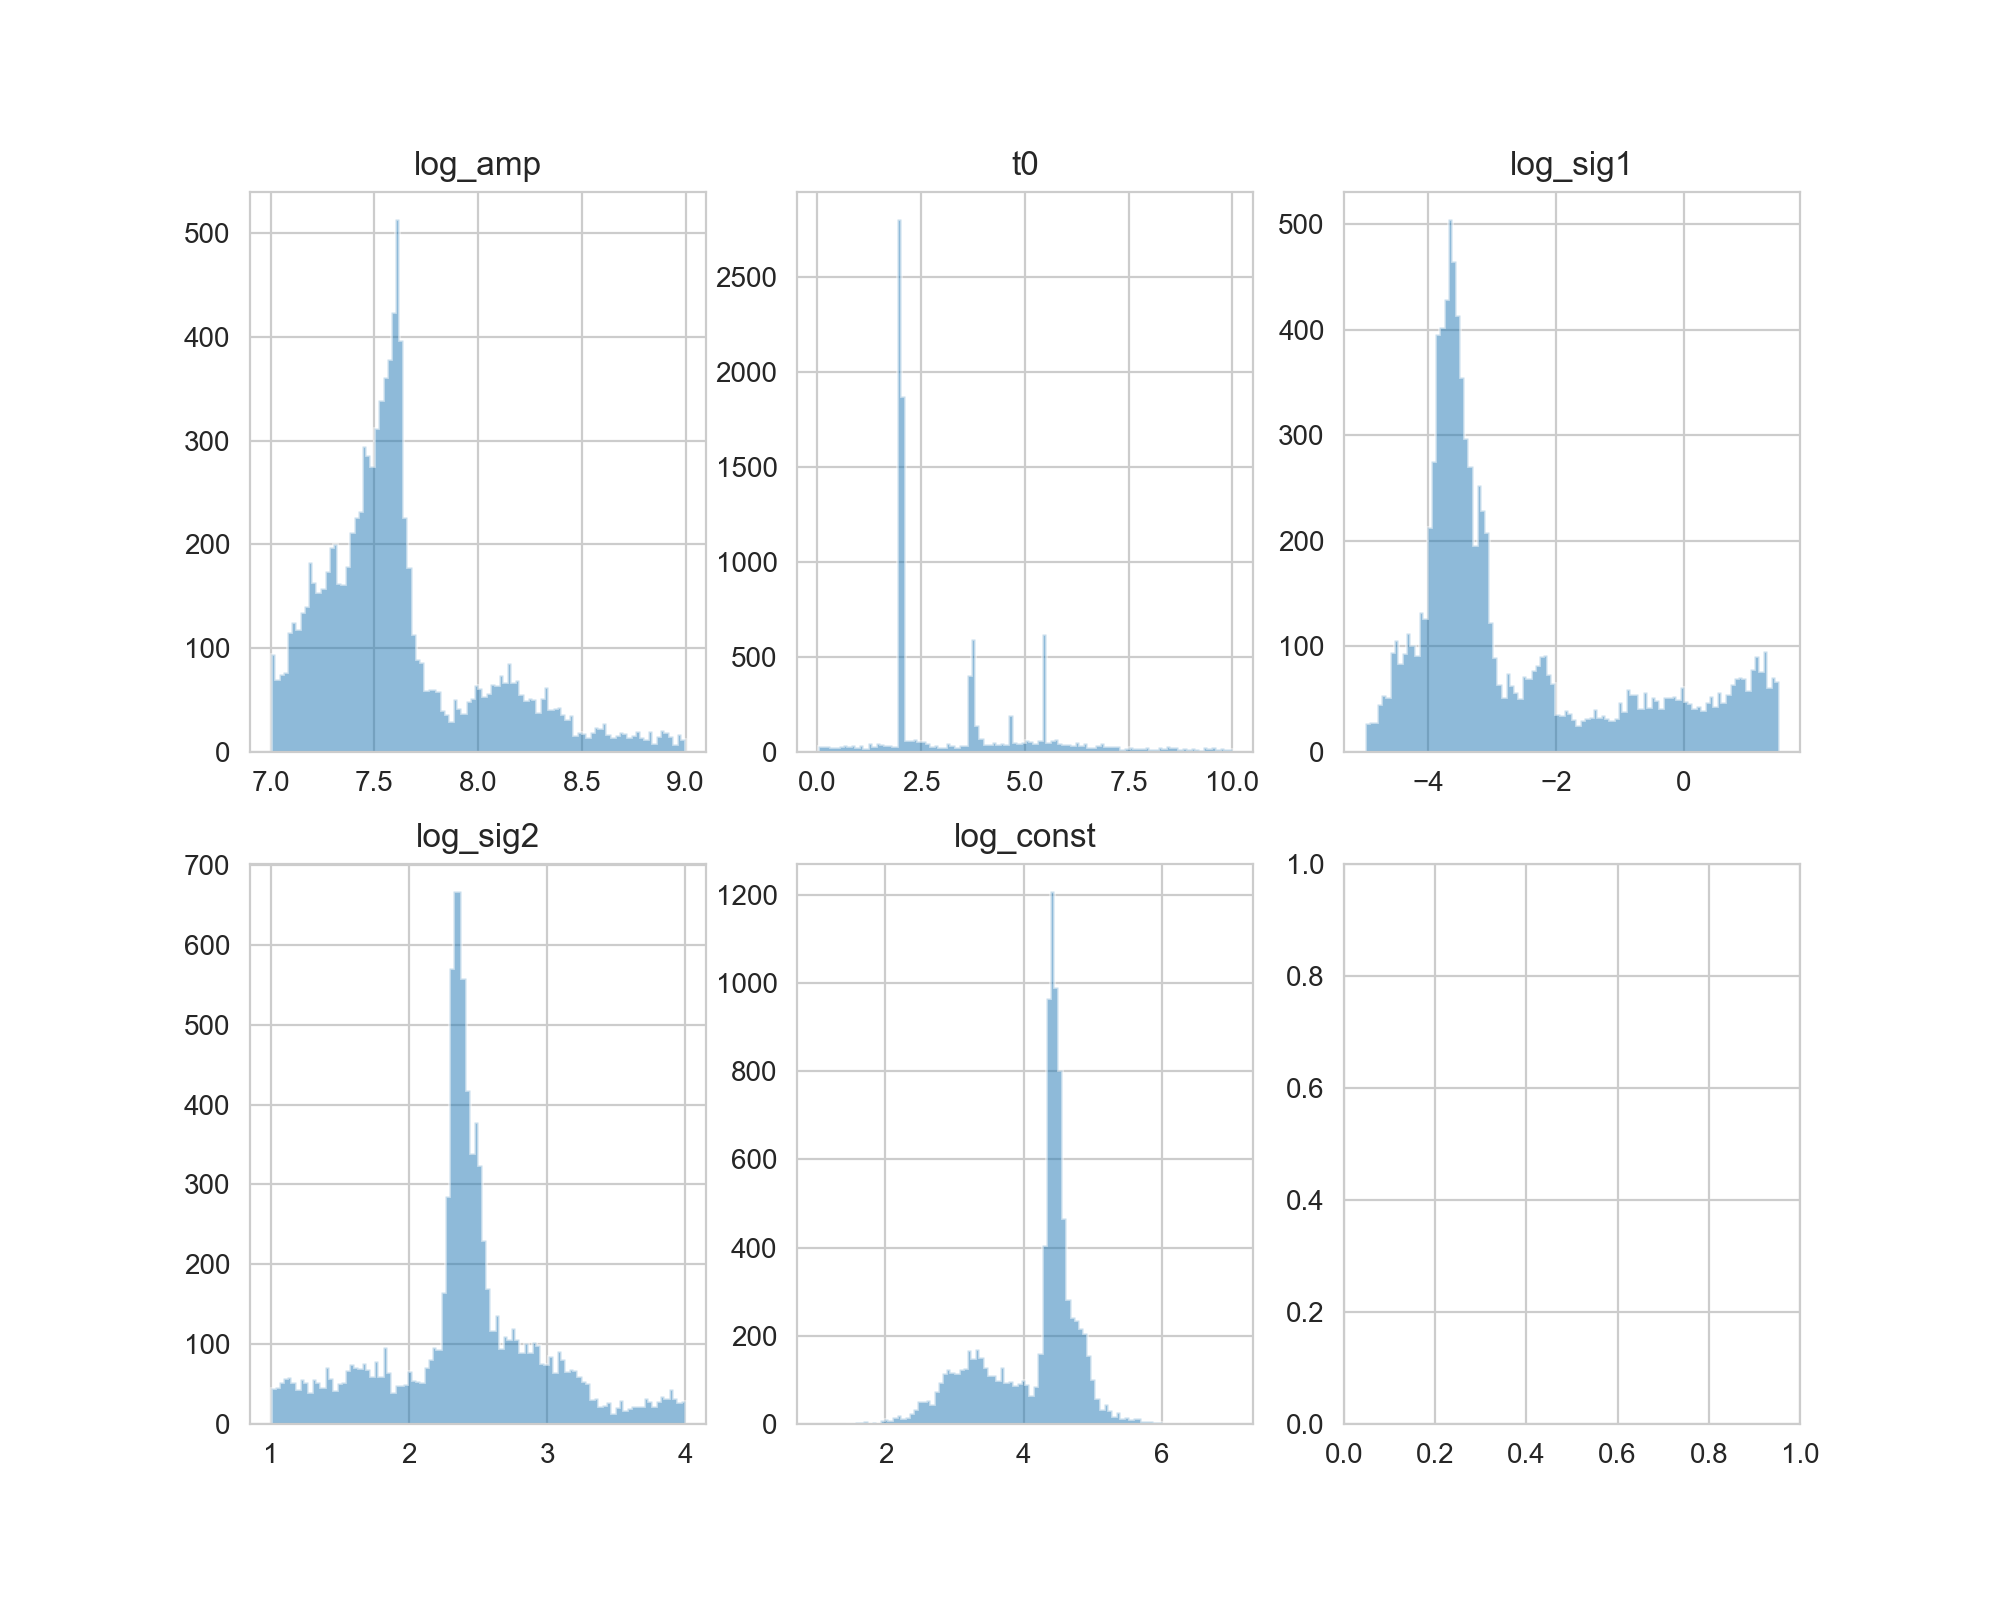

In [195]:
mean_var_names = ["log_amp", "t0", "log_sig1",
                  'log_sig2', "log_const"]

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = np.hstack(axes)

for i, vn in enumerate(mean_var_names):
    samp = samples_qpo[vn].block_until_ready()  
    axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    #axes[i].axvline(mean_params_true[i], lw=2, color="red")

<IPython.core.display.Javascript object>


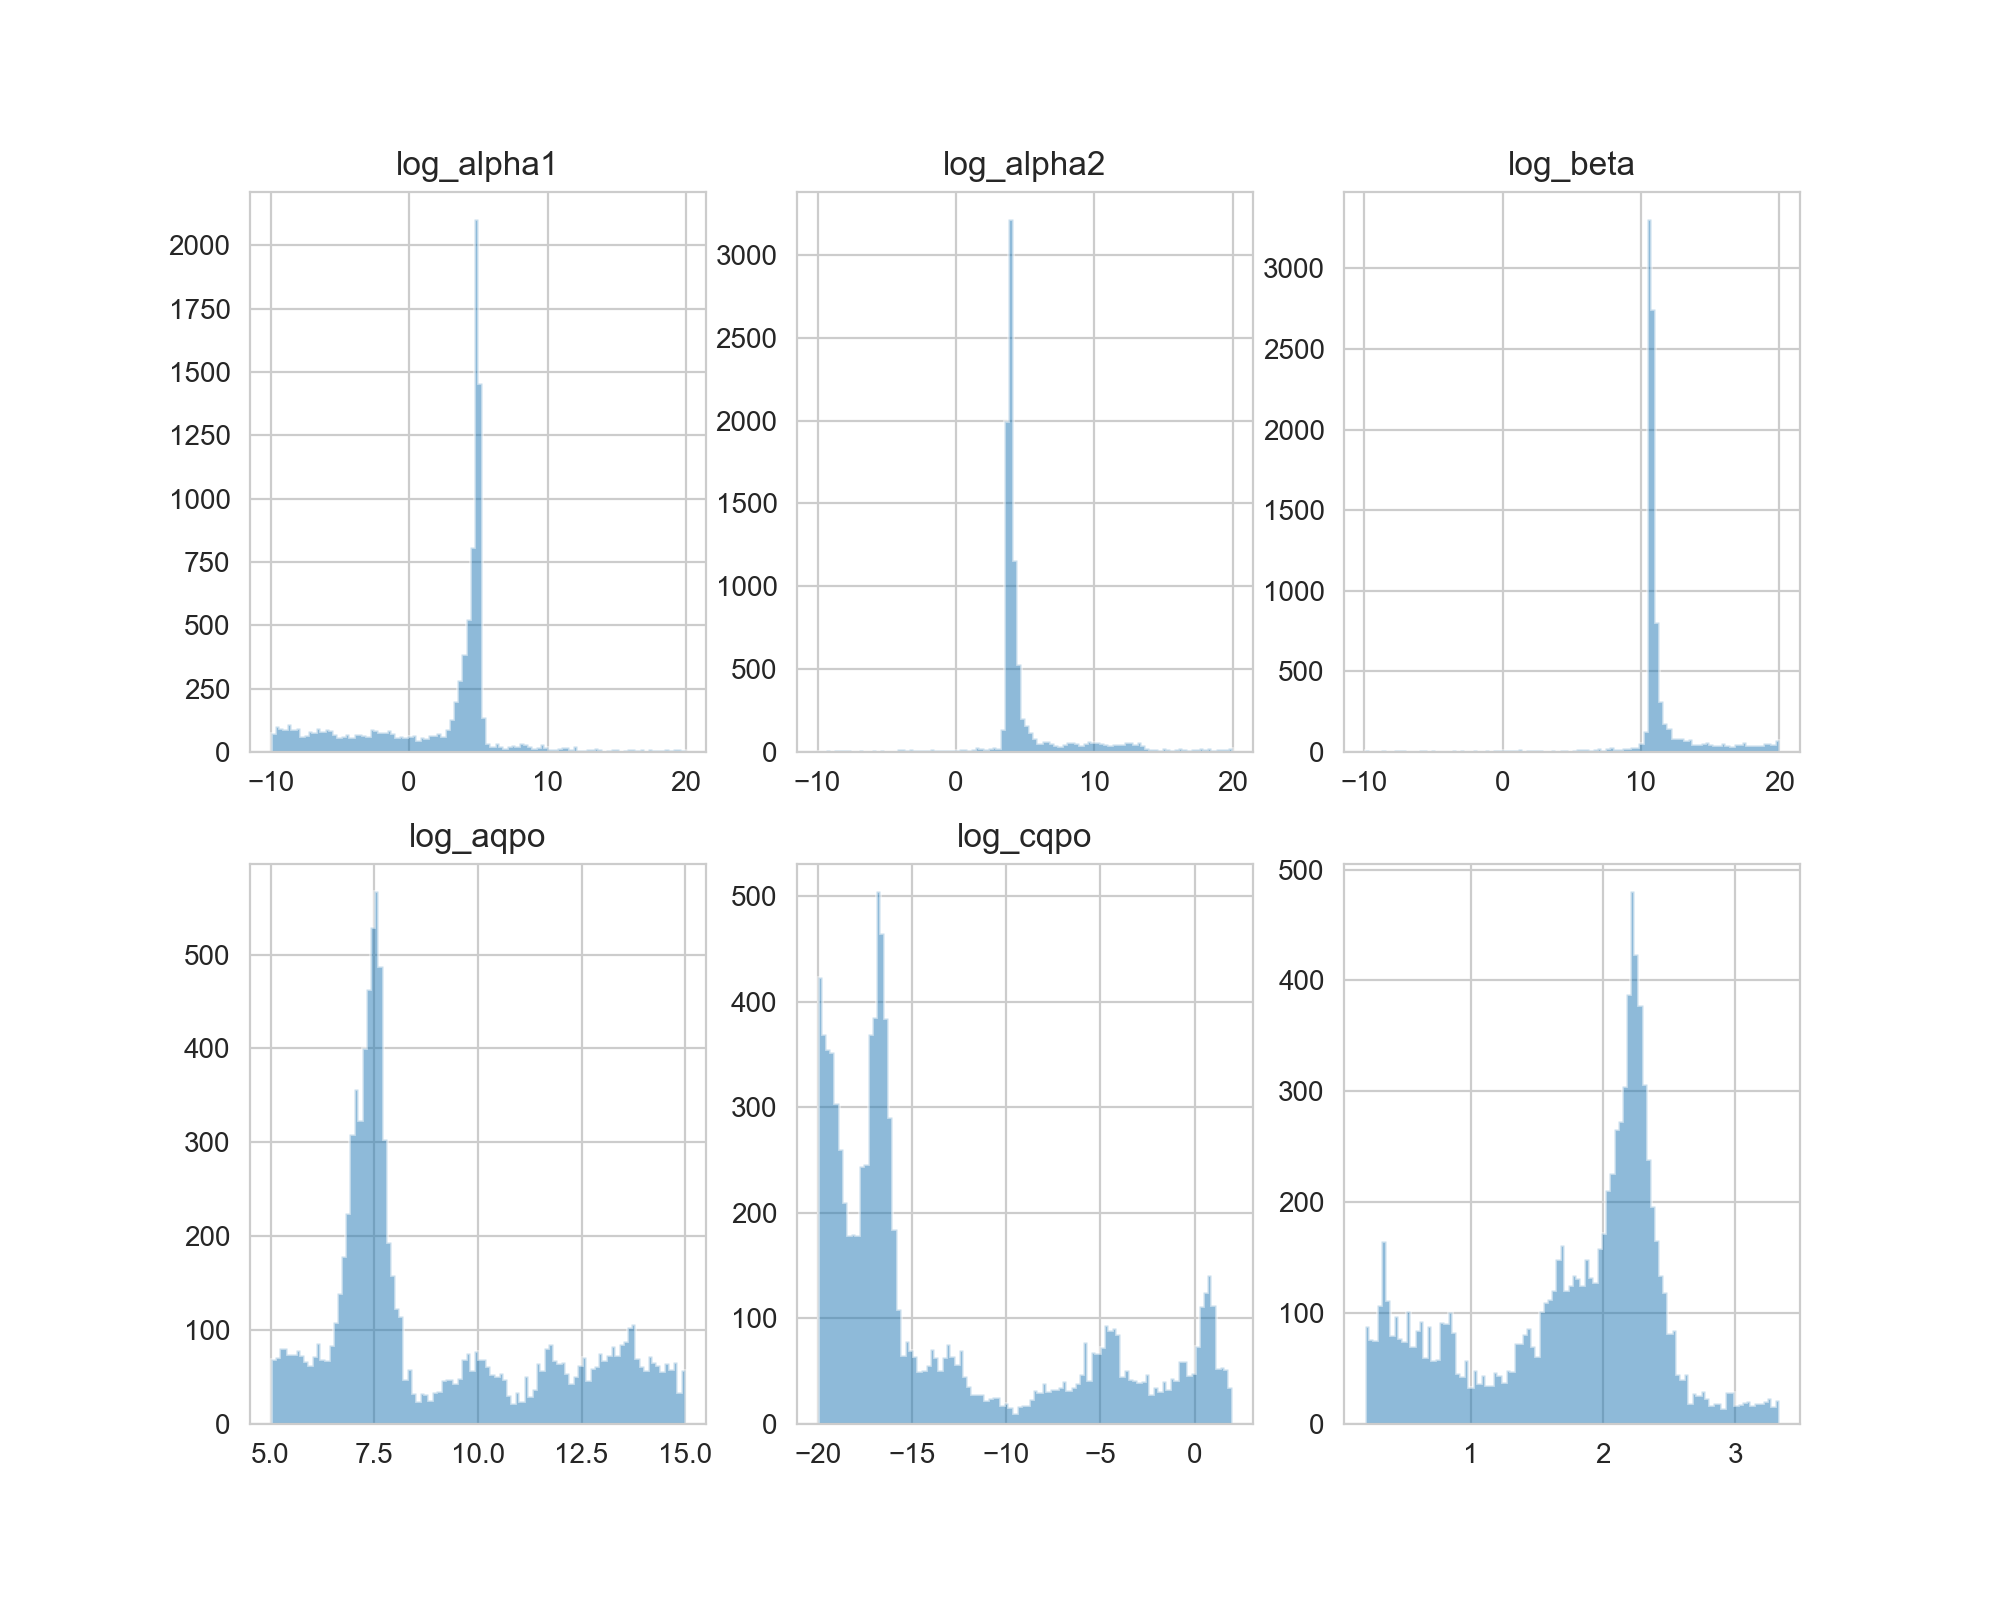

In [196]:
kernel_var_names = ["log_alpha1", "log_alpha2",
                    "log_beta", "log_aqpo", 
                    "log_cqpo", "log_freq"]


fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = np.hstack(axes)

for i, vn in enumerate(kernel_var_names):

    samp = samples_qpo[vn].block_until_ready()  
    if vn == "log_freq":
        axes[i].hist(1./jnp.exp(samp), bins=100, histtype="stepfilled", alpha=0.5)
    else:
        axes[i].hist(samp, bins=100, histtype="stepfilled", alpha=0.5)
        axes[i].set_title(vn)
    #axes[i].axvline(np.log(kernel_params_true[i]), lw=2, color="red")

In [198]:
def lorentzian(freq, amp, f0, fwhm):
    """
    A Lorentzian function (Cauchy distribution)
    
    Parameters
    ----------
    freq : numpy.ndarray
        An array of frequencies for which to 
        compute the Lorentzian
        
    amp : float
        The amplitude of the Lorentzian
        
    f0 : float
        The centroid frequency of the Lorentzian
        
    fwhm : float
        The full-width at half-maximum of the 
        Lorentzian
        
    Returns
    -------
    lor : numpy.ndarray
        The values of the Lorentzian for the 
        given parameters and frequency array
    
    """
    num = amp * fwhm**2.
    denom = fwhm**2. + (freq - f0)**2.0
    
    return num/denom   

<IPython.core.display.Javascript object>


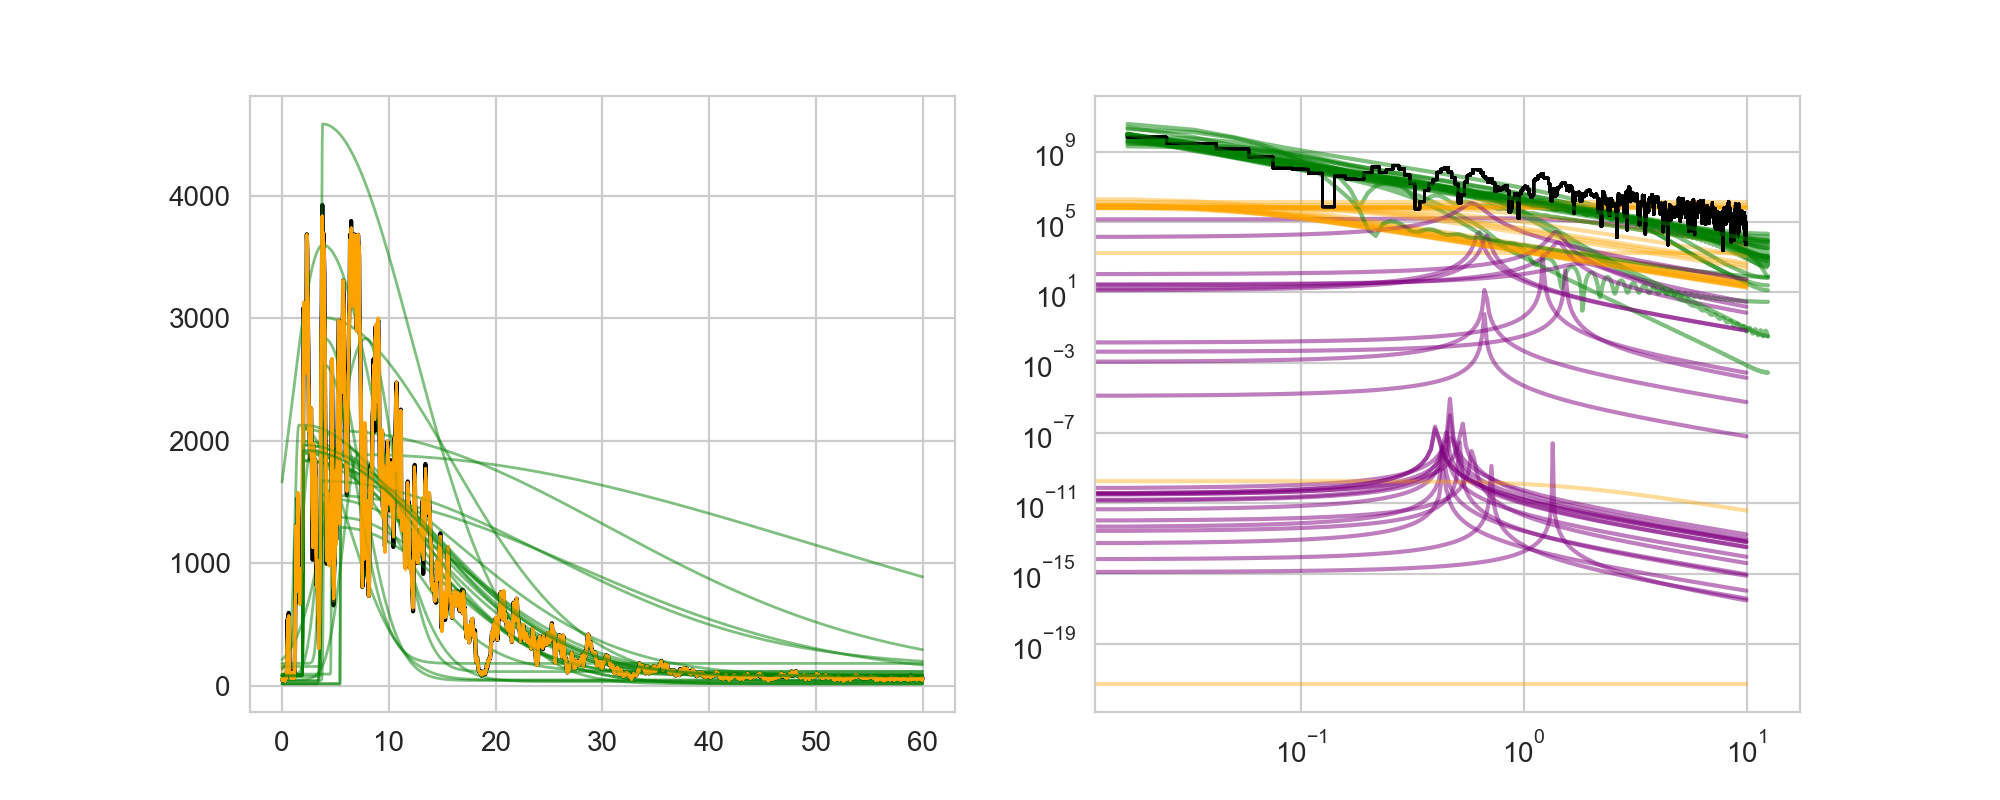

In [199]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc_bgo.time[:npoints], lc_bgo.counts[:npoints], color="black")

np.random.seed(1000)
nsims = 25 # number of simulated light curves / PSDs
nsamples = samples_qpo["log_alpha1"].shape[0]
idx_all = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nsims, replace=False)

# time array for the posterior predictive examples
tpost = np.linspace(0.0, lc_bgo.time[-1], 1500)
dt_post = tpost[1] - tpost[0]

# frequencies for the PSD
freq = np.fft.fftfreq(lc_bgo.n, d=lc_bgo.dt)
freq = freq[:int(lc_bgo.n/2)]

# calculate periodogram for comparison:
ps_bgo = Powerspectrum(lc_bgo, norm="abs")

for idx in idx_all:
    # mean parameters
    params = [samples_qpo["log_amp"][idx],
              samples_qpo["t0"][idx],
              samples_qpo["log_sig1"][idx],
              samples_qpo["log_sig2"][idx],
              samples_qpo["log_const"][idx]]
    
    mean_post = skewgaussian(tpost, params)
    
    # kernel parameters
    alpha_post = [jnp.exp(samples_qpo["log_alpha1"][idx]),
             jnp.exp(samples_qpo["log_alpha2"][idx])]
    
    beta_post = jnp.exp(samples_qpo["log_beta"][idx])
    
    kernel_carma = CARMA.init(alpha=alpha_post, 
                        beta=beta_post)
    
    
    aqpo_post = jnp.exp(samples_qpo["log_aqpo"][idx])
    cqpo_post = jnp.exp(samples_qpo["log_cqpo"][idx])
    freq_post = jnp.exp(samples_qpo['log_freq'][idx])
    
    # QPO kernel
    kernel_qpo = kernels.quasisep.Celerite(
            a=aqpo_post,
            b=0.0,
            c=cqpo_post,
            d=2 * jnp.pi * freq_post
        )
    
    # add kernels together
    kernel_post = kernel_carma + kernel_qpo
    
    gp = GaussianProcess(kernel_post, lc_bgo.time[:npoints], diag=0.01)

    _, cond = gp.condition(lc_bgo.counts[:npoints], tpost, include_mean=True)

    ax1.plot(tpost, cond.loc, lw=1, color="orange", alpha=0.4)
    ax1.plot(tpost, mean_post, lw=1, color="green", alpha=0.5)
    
    # PSD of the CARMA process
    psd_carma = power_spectrum(freq, alpha_post, ma_coefs=[beta_post])
    psd_lor = lorentzian(freq, aqpo_post, freq_post, cqpo_post)
    
    ps_mean = Powerspectrum(Lightcurve(tpost, mean_post, dt=dt_post, skip_checks=True), norm="abs")
    
    ax2.loglog(ps_bgo.freq, ps_bgo.power, lw=1, color="black", ds="steps-mid")
    ax2.loglog(freq, psd_carma, color="orange", alpha=0.4)
    ax2.loglog(ps_mean.freq, ps_mean.power, color="green", alpha=0.5)
    ax2.loglog(freq, psd_lor, color="purple", alpha=0.5)
